https://astroquery.readthedocs.io/en/latest/nasa_exoplanet_archive/nasa_exoplanet_archive.html

data column(https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html)

# import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from astropy import constants as const
from astropy import units as u
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,R_earth,M_earth

## settings

26000 

### parameters name

In [2]:
e = 'pl_orbeccen'
eerr1 = 'pl_orbeccenerr1'
eerr2 = 'pl_orbeccenerr2'

a = 'pl_orbsmax'
aerr1 = 'pl_orbsmaxerr1'
aerr2 = 'pl_orbsmaxerr2'

m_p = 'pl_bmassj'
m_perr1 = 'pl_bmassjerr1'
m_perr2 = 'pl_bmassjerr2'

r_p = 'pl_radj'
r_perr1 = 'pl_radjerr1'
r_perr2 = 'pl_radjerr2'

p = 'pl_orbper'
perr1 = 'pl_orbpererr1'
perr2 = 'pl_orbpererr2'

m_s = 'st_mass'
spt = 'st_spstr'
d = 'sy_dist'
#num = 'pl_pnum'
r_s = 'st_rad'
name = 'hostname'
vsin = 'st_vsin'

In [3]:
df = pd.read_csv('PSCompPars_2021.05.27_11.48.48.csv', index_col=False, float_precision='high',comment='#')
#df.reset_index(drop=True, inplace=True)
df_exo = pd.read_csv('exoplanet.eu_catalog.csv', index_col=False, float_precision='high')
df_exo[:3]

name planet_status  mass  mass_error_min  mass_error_max  mass_sini  \
0  11 Com b     Confirmed   NaN             NaN             NaN       19.4   
1  11 Oph b     Confirmed  21.0             3.0             3.0        NaN   
2  11 UMi b     Confirmed   NaN             NaN             NaN       10.5   

   mass_sini_error_min  mass_sini_error_max  radius  radius_error_min  ...  \
0                 1.50                 1.50     NaN               NaN  ...   
1                  NaN                  NaN     NaN               NaN  ...   
2                 2.47                 2.47     NaN               NaN  ...   

   star_sp_type  star_age  star_age_error_min  star_age_error_max  star_teff  \
0        G8 III       NaN                 NaN                 NaN     4742.0   
1            M9     0.011               0.002               0.002     2375.0   
2         K4III     1.560               0.540               0.540     4340.0   

   star_teff_error_min  star_teff_error_max  star_detected_disc  \
0                100.0                100.0                 NaN   
1                175.0                175.0                 NaN   
2                 70.0                 70.0                 NaN   

   star_magnetic_field    star_alternate_names  
0                  NaN                     NaN  
1                  NaN  Oph 1622-2405, Oph 11A  
2                  NaN                     NaN  

[3 rows x 98 columns]

In [4]:
#make dataframes 
df['density'] = df[m_p]/(4*np.pi*df[r_p]**3/3)
df_exo['density'] = df_exo['mass']/(4*np.pi*df_exo['radius']**3/3)
df_exo['p_s'] = 3.0


df_new = df[(df[d]!= 0.000) & (df['tran_flag']!=0) & (df['rv_flag']!=0)]
df_new['p_s'] = 2 * np.pi * df_new[r_s] * R_sun/(df_new[vsin] * 1e3) / (60**2*24)
df_new.fillna(0,inplace=True)
df_new['p_s'].replace([np.inf, -np.inf], 0, inplace=True)

df_e= df[(df[e] > 0.3) & (df[d]!= 0.000) & (df['tran_flag']!=0) & (df['rv_flag']!=0)]
df_e['p_s'] = 2 * np.pi * df_e[r_s] * R_sun/(df_e[vsin] * 1e3) / (60**2*24)
df_e.fillna(0,inplace=True)
df_e['p_s'].replace([np.inf, -np.inf], 0, inplace=True)


df_rv = df[(df[e]!= 0.000) & (df[d]!= 0.000) & (df['rv_flag']!=0)]
df_hist = df[(df[d]!= 0.000) & (df['tran_flag']!=0) & (df['rv_flag']!=0) & (df[m_p]!=0) & (df[r_p]!=0)]
df_all = df[(df[d]!= 0.000) & (df[m_p]!=0) & (df[r_p]!=0)]


print(len(df_new))
print(len(df_rv))
print(len(df_hist))


737
1195
737


<ipython-input-4-b4f981debbd2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['p_s'] = 2 * np.pi * df_new[r_s] * R_sun/(df_new[vsin] * 1e3) / (60**2*24)
/home/yterada/anaconda3/envs/dmtau/lib/python3.8/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/yterada/anaconda3/envs/dmtau/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

# Definition

In [5]:
#fixed parameters
Epsilon_p = 1
Epsilon_s = 1e-2
alpha_p = 0.26
alpha_s = 0.07

def _tau_omega(params,Omega0_p):
    
    M_p0,M_s0,R_p0,R_s0,a0,p0,e,omega_s0 = params
    
    Q_dash_s = 1e6
    

    if M_p0 > 0.6:
        Q_dash_p = 1e6
    elif M_p0 > 0.01:
        Q_dash_p = 7e4
    else:
        Q_dash_p = 20
        #20

    if omega_s0 > 0.0:
        Omega0_s = omega_s0
    else:
        Omega0_s = 3.0
    #Omega0_s = 3.0    
        
    M_p = M_p0 * M_jup
    M_s = M_s0 * M_sun
    M_t = M_p + M_s
    R_s = R_s0 * R_sun
    R_p = R_p0 * R_jup
    p = p0*24*60**2
    a = a0 * au
    
    n = 2 * np.pi / p
    Omega_p = 2 * np.pi / (Omega0_p*24*60**2)
    Omega_s = 2 * np.pi / (Omega0_s*24*60**2)
    
    #f1 = (1 + 15/4*e**2 + 15/8*e**4 + 5/64*e**6) * (1-e**2)**(13/2)
    #f2 = (1 + 3/2*e**2 + e**4/8) * (1-e**2)**5
    f3 = (1 + (15*e**2)/2 + (45*e**4)/8 + (5*e**6)/16) * (1 - e**2)**(-6)
    f4 = (1 + 3*e**2 + (3*e**4)/8) * (1 - e**2)**(-9/2)
    
    ##tau_omega
    omega_dot_p = (M_s**2/(alpha_p*Epsilon_p*M_p*M_t)) * (9*n/(2*Q_dash_p)) * (R_p/a)**3 * (f3*n - f4*Omega_p)
    omega_dot_s = (M_p**2/(alpha_s*Epsilon_s*M_s*M_t)) * (9*n/(2*Q_dash_s)) * (R_s/a)**3 * (f3*n - f4*Omega_s)
    tau_omega = (Omega_p/abs(omega_dot_p))/(365*24*60**2)
    
    ## tau omega for low eccentricity
    tau_omega_e0 = (0.187*alpha_p*Epsilon_p) * abs((24*60**2/(2*np.pi/Omega_p))/(0.34*np.sqrt(M_s0) * (0.04/a0)**(3/2) - (24*60**2/((2*np.pi)/Omega_p))))*(Q_dash_p/1e6) *  M_p0 * (1/M_s0)**(3/2) * (a0/(0.04))**(9/2) * (1/R_p0)**3
    tau_omega_e0 = tau_omega_e0*1e6
    
    return tau_omega, tau_omega_e0


def timescale(params,Omega0_p):
    M_p0,M_s0,R_p0,R_s0,a0,p0,e,omega_s0 = params
    
    Q_dash_s = 1e6
    
    if M_p0 > 0.6:
        Q_dash_p = 1e4
    elif M_p0 > 0.01:
        Q_dash_p = 7e4 #7e4
    else:
        Q_dash_p = 20
        #20
        
    if omega_s0 > 0.0:
        Omega0_s = omega_s0
    else:
        Omega0_s = 3.0
    #Omega0_s = 3.0    
        
    M_p = M_p0 * M_jup
    M_s = M_s0 * M_sun
    M_t = M_p + M_s
    R_s = R_s0 * R_sun
    R_p = R_p0 * R_jup
    p = p0*24*60**2
    a = a0 * au
    
    n = 2 * np.pi / p
    Omega_p = 2 * np.pi / (Omega0_p*24*60**2)
    Omega_s = 2 * np.pi / (Omega0_s*24*60**2)
    
    f1 = (1 + 15/4*e**2 + 15/8*e**4 + 5/64*e**6) * (1-e**2)**(13/2)
    f2 = (1 + 3/2*e**2 + e**4/8) * (1-e**2)**5
    #f3 = (1 + (15*e**2)/2 + (45*e**4)/8 + (5*e**6)/16) * (1 - e**2)**(-6)
    #f4 = (1 + 3*e**2 + (3*e**4)/8) * (1 - e**2)**(-9/2)
    
    ##tau_omega
    #omega_dot_p = (M_s**2/(alpha_p*Epsilon_p*M_p*M_t)) * (9*n/(2*Q_dash_p)) * (R_p/a)**3 * (f3*n - f4*Omega_p)
    #omega_dot_s = (M_p**2/(alpha_s*Epsilon_s*M_s*M_t)) * (9*n/(2*Q_dash_s)) * (R_s/a)**3 * (f3*n - f4*Omega_s)
    #tau_omega = (Omega_p/abs(omega_dot_p))/365
    
    
    ##omega_dot(e=0)
    #tau_omega_e0 = (0.187*alpha_p*Epsilon_p) * abs((1/Omega_p)/(0.34*np.sqrt(M_s) * (0.04/a)**(3/2) - (1/Omega_p)))*(Q_dash_p/1e6) *  M_p * (1/M_s)**(3/2) * (a/0.04)**(9/2) * (1/R_p)**3
    
    

    J0 = M_p * np.sqrt(G*M_t*a*(1-e**2))
    #J_dot_p = (-1*alpha*Epsilon*J0*M_p/(np.sqrt(1-e**2)*M_p)) * (R_p/a)**2 * (omega_dot_p/n)
    J_dot_p = (9*J0*M_s**2/(M_p*M_t)) * (f4*Omega_p - f3*n)/(2*Q_dash_p*np.sqrt(1-e**2)) * (R_p/a)**5
    J_dot_s = (9*J0*M_p**2/(M_p*M_t)) * (f4*Omega_s - f3*n)/(2*Q_dash_s*np.sqrt(1-e**2)) * (R_s/a)**5
    
    ##tau_e
    g_p = (-81*e/(2*Q_dash_p)) * (M_s/M_p) * (R_p/a)**5 * (f1*n - 11*f2*Omega_p/18)
    g_s = (-81*e/(2*Q_dash_s)) * (M_p/M_s) * (R_s/a)**5 * (f1*n - 11*f2*Omega_s/18)
    e_dot = g_p + g_s
    tau_e = e/abs(e_dot)
    
    ##tau_e for low eccentricitay 
    #unit: Gyr
    if e < 0.3:
        tau_e0_Gyr = 0.33 * (Q_dash_p/1e6) * (M_p0) * (1/M_s0)**(3/2) * (a0/0.04)**(13/2) * (1/R_p0)**5
        tau_e0 = abs(tau_e0_Gyr) * 1e9
    else:
        tau_e0 = 0.0
    ##tau_a
    a_dot = a * (2*e*e_dot/(1-e**2) + 2*(J_dot_p+J_dot_s)/J0)
    a_a_dot = (2*e*e_dot/(1-e**2) + 2*(J_dot_p+J_dot_s)/J0)**(-1)
    tau_a = a / abs(a_dot)
    
    return tau_e, tau_a, tau_e0, g_s, g_p, tau_omega_e0


def _omega_ps(e, P_orb):
    
    P_orb_s = 2 * np.pi/P_orb
    
    #Hut-eq(42): Omega_ps/n
    o_ps_n = (1 + 15*e**2/2 + 45*e**4/8 + 5*e**6/16)/((1 + 3*e**2 + 3*e**4/8)*(1-e**2)**(3/2)) 

    #Hut - eq(44): n_p - the orbital angular velocity at periastron
    n = 2*np.pi/P_orb_s
    n_p = (1 + e)**2 * n / (1 - e**2)**(3/2)

    #Hut - eq(45): Omega_ps/n_p
    ratio = (1 + 15*e**2/2 + 45*e**4/8 + 5*e**6/16)/((1 + 3*e**2 + 3*e**4/8)*(1+e)**2)
    omega_ps = 2*np.pi/(n_p * ratio)
    
    return o_ps_n, n_p, ratio, omega_ps


# Calculate timescales

Condition  
1.Initial a, e, p_s = present value * 1.01 (timescale = How long does it take to foget the situation, if each value were one percent larger than it is now.)   
2.Stellar rotation period = 3.0 days (I need to fix it)   
3.Q-values are classified according to the mass of the planets.


## Test calculation

In [6]:
#NASA Exoplanet Archive

loc_ar = df_new.index.values
df_new['t_omega'] = 0
df_new['t_omega_0'] = 0
df_new['omega_ps'] = 0
t_omegas = []
t_omegas_0 = []
omega_ps = []


for i in range(len(df_new)):
    ind = loc_ar[i]
    #M_p = df_new.loc[ind][m_p]
    M_p = df_new.loc[ind][m_p]
    M_s = df_new.loc[ind][m_s]
    R_p = df_new.loc[ind][r_p]
    R_s = df_new.loc[ind][r_s]
    a0 = df_new.loc[ind][a]
    p0 = df_new.loc[ind][p]
    e0 = df_new.loc[ind][e]
    p_s0 = df_new.loc[ind]['p_s']
    params = [M_p,M_s,R_p,R_s,a0,p0,e0,p_s0]
 
    #t_omega = _tau_omega(params, 0.5)
    t_omega,t_omega_e0  = _tau_omega(params, 3.0)
    ratio_ps_n, n_p, ratio_ps_np, omega_psd = _omega_ps(e0, p0)
    
    t_omegas.append(t_omega)
    t_omegas_0.append(t_omega_e0)
    omega_ps.append(omega_psd)
    #df_new.loc[ind]['t_omega'] = t_omega
    #df_new.loc[ind]['t_e'] = t_e
    #df_new.loc[ind]['t_a'] =t_a

df_new['t_omega'] = t_omegas
df_new['t_omega_0'] = t_omegas_0
df_new['omega_ps'] = omega_ps

<ipython-input-6-0b7ccc855d84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['t_omega'] = 0
<ipython-input-6-0b7ccc855d84>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['t_omega_0'] = 0
<ipython-input-6-0b7ccc855d84>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [10]:
plt.plot(df_new[p],df_new['t_omega'],'o', label='taaa')
plt.xlim(0,10)
plt.ylim(1e3,1e7)

(1000.0, 10000000.0)

Text(0.5, 1.0, 'tau_omega, omega_p=1day')

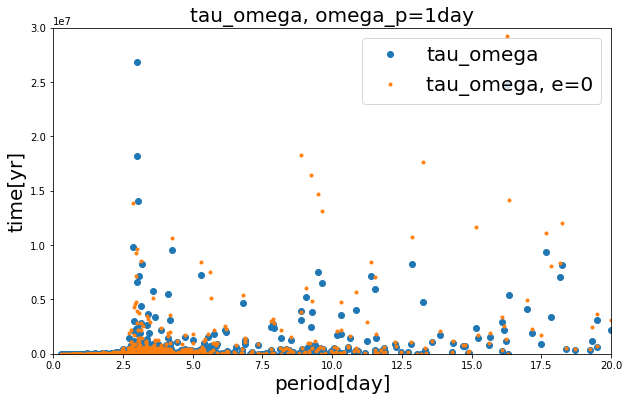

In [24]:
plt.figure(figsize=(10,6))
plt.plot(df_new[p],df_new['t_omega'],'o', label='tau_omega')
plt.plot(df_new[p],df_new['t_omega_0'],'.',label='tau_omega, e=0')
plt.ylim(0,3e7)
plt.xlim(0,20)
plt.xlabel('period[day]',fontsize=20)
plt.ylabel('time[yr]',fontsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.title('tau_omega, omega_p=1day',fontsize=20)
#plt.savefig('tau_omega-p0_1day.pdf')

In [9]:
#NASA Exoplanet Archive

loc_ar_e = df_e.index.values
df_e['t_omega'] = 0
t_omegas_e = []


for i in range(len(df_e)):
    ind = loc_ar_e[i]
    #M_p = df_new.loc[ind][m_p]
    M_p = df_e.loc[ind][m_p]
    M_s = df_e.loc[ind][m_s]
    R_p = df_e.loc[ind][r_p]
    R_s = df_e.loc[ind][r_s]
    a0 = df_e.loc[ind][a]
    p0 = df_e.loc[ind][p]
    e0 = df_e.loc[ind][e]
    p_s0 = df_e.loc[ind]['p_s']
    params = [M_p,M_s,R_p,R_s,a0,p0,e0,p_s0]
 
    t_omega, t_omega_e0  = _tau_omega(params, 3.0)
    
    t_omegas_e.append(t_omega)
    #df_new.loc[ind]['t_omega'] = t_omega
    #df_new.loc[ind]['t_e'] = t_e
    #df_new.loc[ind]['t_a'] =t_a

df_e['t_omega'] = t_omegas_e

<ipython-input-9-c1f3fbdcb8fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e['t_omega'] = 0
<ipython-input-9-c1f3fbdcb8fc>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e['t_omega'] = t_omegas_e


(0.0, 50.0)

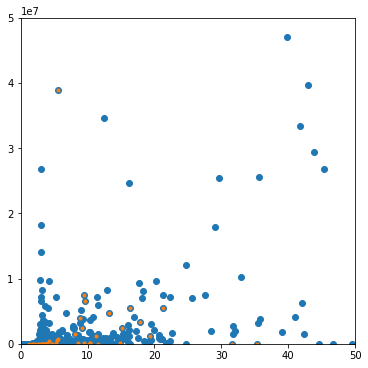

In [26]:
plt.figure(figsize=(6,6))
plt.plot(df_new[p],df_new['t_omega'],'o')
plt.plot(df_e[p],df_e['t_omega'],'.')
plt.ylim(0,5e7)
plt.xlim(0,50)

#NASA Exoplanet Archive

loc_ar = df_new.index.values
df_new['t_omega'] = 0
df_new['t_e'] = 0
df_new['t_a'] = 0
df_new['omega_ps'] = 0

t_omegas = []
t_es = []
t_as = []
t_e0s = []
g_ps = []
g_ss = []
omega_pss = []

for i in range(len(df_new)):
    ind = loc_ar[i]
    #M_p = df_new.loc[ind][m_p]
    M_p = df_new.loc[ind][m_p]
    M_s = df_new.loc[ind][m_s]
    R_p = df_new.loc[ind][r_p]
    R_s = df_new.loc[ind][r_s]
    a0 = df_new.loc[ind][a] * 1.01
    p0 = df_new.loc[ind][p] * 1.01
    e0 = df_new.loc[ind][e] * 1.01
    p_s0 = df_new.loc[ind]['p_s']
    params = [M_p,M_s,R_p,R_s,a0,p0,e0,p_s0]
 
    t_omega, t_e, t_a, t_e0, g_s, g_p  = timescale(params, 0.5)
    
    t_omegas.append(t_omega)
    t_es.append(t_e)
    t_as.append(t_a)
    t_e0s.append(t_e0)
    g_ps.append(g_p)
    g_ss.append(g_s)
    #df_new.loc[ind]['t_omega'] = t_omega
    #df_new.loc[ind]['t_e'] = t_e
    #df_new.loc[ind]['t_a'] =t_a

df_new['t_omega'] = t_omegas
df_new['t_e'] = t_es
df_new['t_a'] = t_as 
df_new['t_e0'] = t_e0s

In [7]:
# exoplanet.eu
loc_ar = df_exo.index.values
df_exo['t_omega'] = 0
df_exo['t_e'] = 0
df_exo['t_a'] = 0

exo_t_omegas = []
exo_t_es = []
exo_t_as = []
exo_t_e0s = []
exo_g_ps = []
exo_g_ss = []

#df_exo['']
for i in range(len(df_exo)):
    ind = loc_ar[i]
    M_p = df_exo.loc[ind]['mass']
    M_s = df_exo.loc[ind]['star_mass']
    R_p = df_exo.loc[ind]['radius']
    R_s = df_exo.loc[ind]['star_radius']
    a0 = df_exo.loc[ind]['semi_major_axis'] * 1.01
    p0 = df_exo.loc[ind]['orbital_period'] * 1.01
    e0 = df_exo.loc[ind]['eccentricity'] * 1.01
    p_s0 = df_exo.loc[ind]['p_s']
    params = [M_p,M_s,R_p,R_s,a0,p0,e0,p_s0]
 
    t_omega, t_e, t_a, t_e0, g_s, g_p  = timescale(params, 0.5)
    exo_t_omegas.append(t_omega)
    exo_t_es.append(t_e)
    exo_t_as.append(t_a)
    exo_t_e0s.append(t_e0)
    exo_g_ps.append(g_p)
    exo_g_ss.append(g_s)
    #df_exo.loc[ind]['t_omega'] = t_omega
    #df_exo.loc[ind]['t_e'] = t_e
    #df_exo.loc[ind]['t_a'] =t_a

df_exo['t_omega'] = exo_t_omegas
df_exo['t_e'] = exo_t_es
df_exo['t_a'] = exo_t_as 
df_exo['t_e0'] = exo_t_e0s

<ipython-input-5-48b90b3bdc84>:37: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (1 + 15/4*e**2 + 15/8*e**4 + 5/64*e**6) * (1-e**2)**(13/2)
<ipython-input-5-48b90b3bdc84>:40: RuntimeWarning: invalid value encountered in double_scalars
  f4 = (1 + 3*e**2 + (3*e**4)/8) * (1 - e**2)**(-9/2)
<ipython-input-5-48b90b3bdc84>:56: RuntimeWarning: invalid value encountered in sqrt
  J_dot_p = (9*J0*M_s**2/(M_p*M_t)) * (f4*Omega_p - f3*n)/(2*Q_dash_p*np.sqrt(1-e**2)) * (R_p/a)**5
<ipython-input-5-48b90b3bdc84>:57: RuntimeWarning: invalid value encountered in sqrt
  J_dot_s = (9*J0*M_p**2/(M_p*M_t)) * (f4*Omega_s - f3*n)/(2*Q_dash_s*np.sqrt(1-e**2)) * (R_s/a)**5


### tau_omega

<ipython-input-8-90ebcd3839f9>:2: RuntimeWarning: divide by zero encountered in log10
  map2 = plt.scatter(df_new[p], np.log10(t_omegas), c=df_new[r_p], cmap='viridis', vmin=0, vmax=2, alpha=0.45)


(0.0, 8.0)

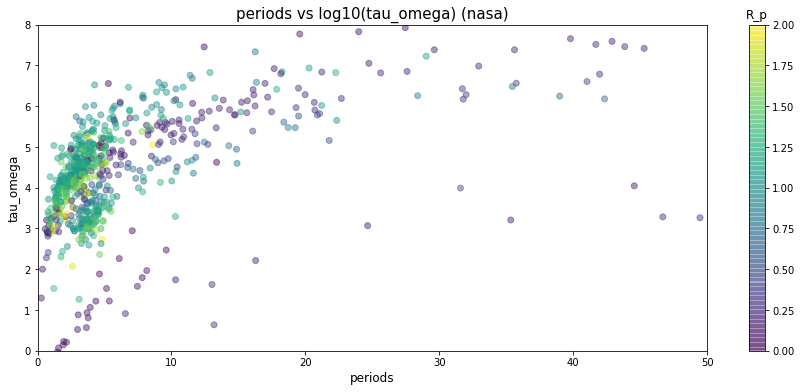

In [8]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_new[p], np.log10(t_omegas), c=df_new[r_p], cmap='viridis', vmin=0, vmax=2, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('R_p')
plt.title('periods vs log10(tau_omega) (nasa)', fontsize=15)
plt.xlabel('periods', fontsize=12)
plt.ylabel('tau_omega', fontsize=12)

plt.xlim(0,50)
plt.ylim(0,8)

<ipython-input-249-1f34d910803c>:2: RuntimeWarning: divide by zero encountered in log10
  map2 = plt.scatter(df_exo['orbital_period'], np.log10(exo_t_omegas), c=df_exo['radius'], cmap='viridis', vmin=0, vmax=2, alpha=0.45)


(0.0, 8.0)

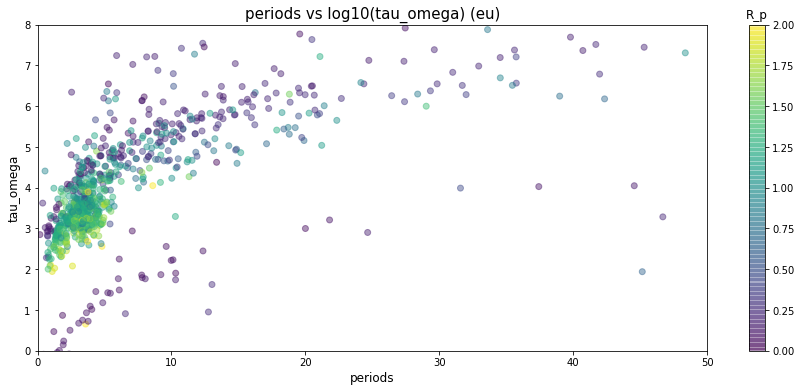

In [249]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_exo['orbital_period'], np.log10(exo_t_omegas), c=df_exo['radius'], cmap='viridis', vmin=0, vmax=2, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('R_p')
plt.title('periods vs log10(tau_omega) (eu)', fontsize=15)
plt.xlabel('periods', fontsize=12)
plt.ylabel('tau_omega', fontsize=12)

plt.xlim(0,50)
plt.ylim(0,8)

#### comments(528)   
the following plots for high density planets with low mass host stars

<ipython-input-256-292627f42d12>:2: RuntimeWarning: divide by zero encountered in log10
  map2 = plt.scatter(df_new[p], np.log10(t_omegas), c=df_new[m_s], cmap='viridis', vmin=0, vmax=0.7, alpha=0.45)


(0.0, 8.0)

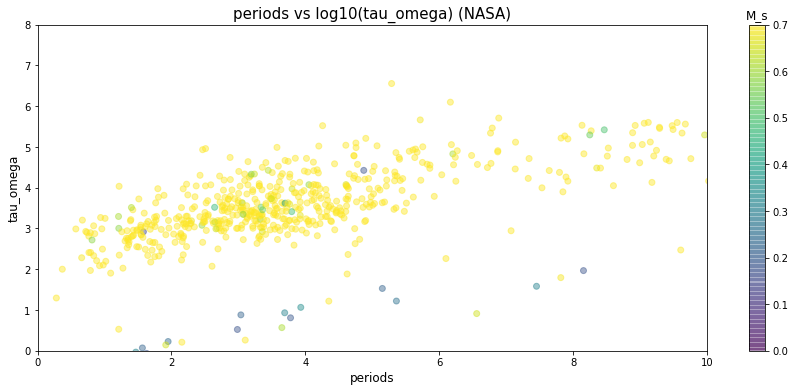

In [256]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_new[p], np.log10(t_omegas), c=df_new[m_s], cmap='viridis', vmin=0, vmax=0.7, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_s')
plt.title('periods vs log10(tau_omega) (NASA)', fontsize=15)
plt.xlabel('periods', fontsize=12)
plt.ylabel('tau_omega', fontsize=12)

plt.xlim(0,10)
plt.ylim(0,8)

<ipython-input-254-f3c46a4d0744>:2: RuntimeWarning: divide by zero encountered in log10
  map2 = plt.scatter(df_exo['orbital_period'], np.log10(exo_t_omegas), c=df_exo['star_mass'], cmap='viridis', vmin=0, vmax=0.7, alpha=0.45)


(0.0, 8.0)

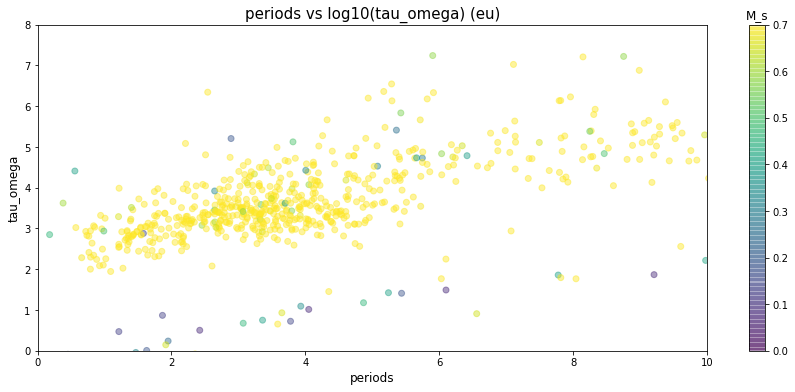

In [254]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_exo['orbital_period'], np.log10(exo_t_omegas), c=df_exo['star_mass'], cmap='viridis', vmin=0, vmax=0.7, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_s')
plt.title('periods vs log10(tau_omega) (eu)', fontsize=15)
plt.xlabel('periods', fontsize=12)
plt.ylabel('tau_omega', fontsize=12)

plt.xlim(0,10)
plt.ylim(0,8)

#### comments(528)  
I tested various Q'_p value. I confirmed that this was the cause of the two separate distributions of low-mass planets.   
Also, I calculated tau_omega using exoplanet.eu data. 

### tau_e test

In [228]:
g_ss_array = np.array(g_ss)
np.where(g_ss_array==np.inf, 0, g_ss_array) 
np.where(g_ss_array==np.nan, 0, g_ss_array) 
g_ps_array = np.array(g_ps)
np.where(g_ps_array==np.inf, 0, g_ps_array) 
np.where(g_ps_array==np.nan, 0, g_ps_array) 
#g_ss_array.replace([np.inf, -np.inf], -1, inplace=True)

#plt.hist(np.log10(g_ss_arrayy))

array([-3.01681834e-12,  1.59840432e-13,  0.00000000e+00,  0.00000000e+00,
        2.20776143e-13,  0.00000000e+00,  2.66989606e-10,  0.00000000e+00,
        0.00000000e+00,  1.00634778e-10,  0.00000000e+00,  1.64897959e-10,
        3.00868438e-11,  6.51957226e-11,  1.38080691e-13,  0.00000000e+00,
        5.26965333e-13,  1.79274731e-11,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.65340158e-12,  9.12567211e-12,
        3.50944009e-11,  0.00000000e+00,  4.10444836e-14,  1.83692184e-11,
        0.00000000e+00,  2.89637162e-10,  1.14396367e-12,  0.00000000e+00,
        0.00000000e+00,  1.44418095e-15,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  4.96784695e-14,  0.00000000e+00,  0.00000000e+00,
        1.35584031e-13,  1.66510639e-14,  5.17331535e-15,  1.51530967e-08,
        0.00000000e+00, -0.00000000e+00,  4.89592856e-16,  3.54982268e-12,
        0.00000000e+00,  0.00000000e+00,  2.27311535e-11,  4.17620017e-09,
        0.00000000e+00,  

<ipython-input-294-424a63ca0f70>:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(df_new[p],np.log10(abs(g_ps_array)),label='g_p')
<ipython-input-294-424a63ca0f70>:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(df_new[p],np.log10(abs(g_ss_array)),label='g_s')


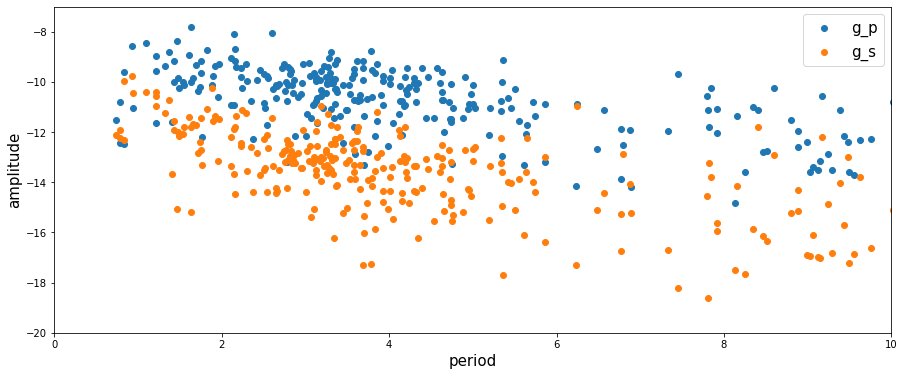

In [294]:
plt.figure(figsize=(15,6))
plt.scatter(df_new[p],np.log10(abs(g_ps_array)),label='g_p')
plt.scatter(df_new[p],np.log10(abs(g_ss_array)),label='g_s')
plt.xlim(0,10)
plt.ylim(-20,-7)
plt.xlabel('period',fontsize=15)
plt.ylabel('amplitude',fontsize=15)
plt.legend(fontsize=15)

$$ \tau_e = \frac{e}{\lvert \dot{e} \rvert}$$  
$$ \dot{e} = g_p + g_s $$ 

#### comments(528)   
g_s is more contributory?   
I changed Q'_s value (1e6 - 1e8) but no significant difference because most of the short orbiting planets have low eccentricity?

<ipython-input-280-f76c2b9ac8f0>:3: RuntimeWarning: divide by zero encountered in log10
  map2 = plt.scatter(df_new[p], np.log10(t_e0s), c=df_new[m_p], cmap='viridis', vmin=0, vmax=2, alpha=0.45)
No handles with labels found to put in legend.


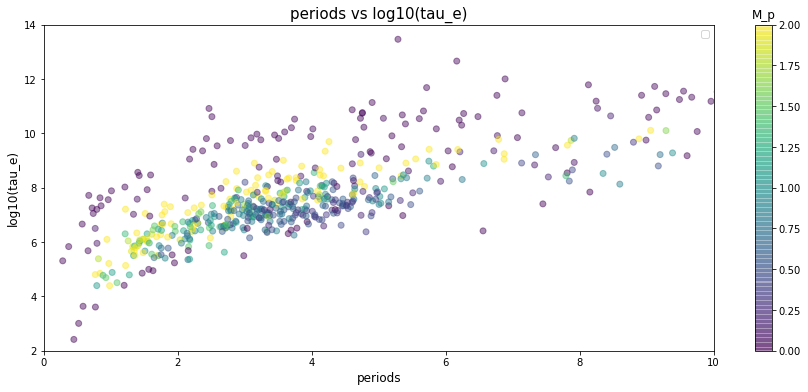

In [280]:
plt.figure(figsize=(15,6))
#plt.scatter(df_new[p], np.log10(t_e0s),c='red',s=2.5, label='eq(18), low e')
map2 = plt.scatter(df_new[p], np.log10(t_e0s), c=df_new[m_p], cmap='viridis', vmin=0, vmax=2, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.title('periods vs log10(tau_e)', fontsize=15)
plt.xlabel('periods', fontsize=12)
plt.ylabel('log10(tau_e)', fontsize=12)
plt.xlim(0,10)
plt.ylim(2.0,14.0)
plt.legend()

737
num(e<0.3 & p<10) =  552
num(e>0.3 & p<10) =  32
num(tau_e!=0 & p<10) =  549


<ipython-input-293-e27dbf505e90>:7: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(df_new[p], np.log10(t_e0s),c='red',s=2.5, label='eq(18), low e')
<ipython-input-293-e27dbf505e90>:8: RuntimeWarning: divide by zero encountered in log10
  map2 = plt.scatter(df_new[p], np.log10(t_es), c=df_new[m_p], cmap='viridis', vmin=0, vmax=2, alpha=0.45)


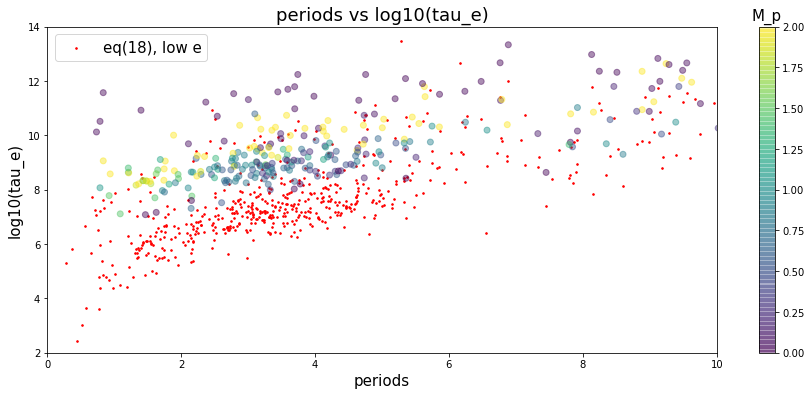

In [293]:
print(len(df_new))
print('num(e<0.3 & p<10) = ',((df_new[e] < 0.3) &(df_new[p] < 10)).sum())
print('num(e>0.3 & p<10) = ',((df_new[e] > 0.3) &(df_new[p] < 10)).sum())
print ('num(tau_e!=0 & p<10) = ',((df_new['t_e0'] != 0)&(df_new[p]<10)).sum())

plt.figure(figsize=(15,6))
plt.scatter(df_new[p], np.log10(t_e0s),c='red',s=2.5, label='eq(18), low e')
map2 = plt.scatter(df_new[p], np.log10(t_es), c=df_new[m_p], cmap='viridis', vmin=0, vmax=2, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p',fontsize=15)
plt.title('periods vs log10(tau_e)', fontsize=18)
plt.xlabel('periods', fontsize=15)
plt.ylabel('log10(tau_e)', fontsize=15)
plt.xlim(0,10)
plt.ylim(2.0,14.0)
plt.legend(fontsize=15)

#### comments(528)   
Over 90% of planetary systems have eccentricity less than 0.3, so I plotted all systems.   
I don't know why the difference of more than two orders of magnitude.....

### tau_a

(5.5, 16.0)

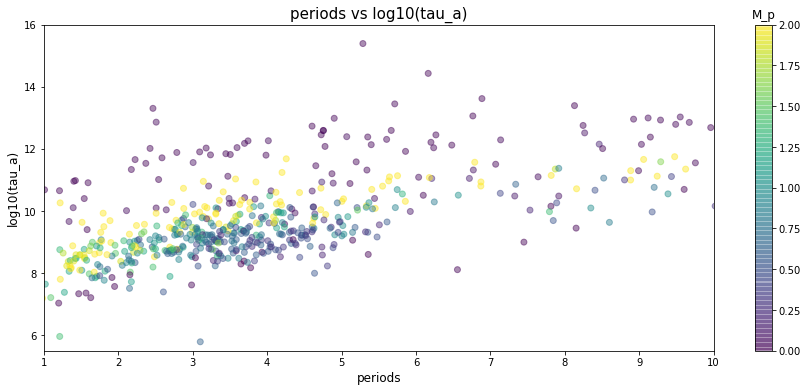

In [38]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_new[p], np.log10(t_as), c=df_new[m_p], cmap='viridis', vmin=0, vmax=2, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.title('periods vs log10(tau_a)', fontsize=15)
plt.xlabel('periods', fontsize=12)
plt.ylabel('log10(tau_a)', fontsize=12)

plt.xlim(1,10)
plt.ylim(5.5,16)

## relation between tau and mass/density

<ipython-input-77-074439cb88fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['density'] = df_new[m_p]/(4*np.pi*df_new[r_p]**3/3)


(0.0, 3.0)

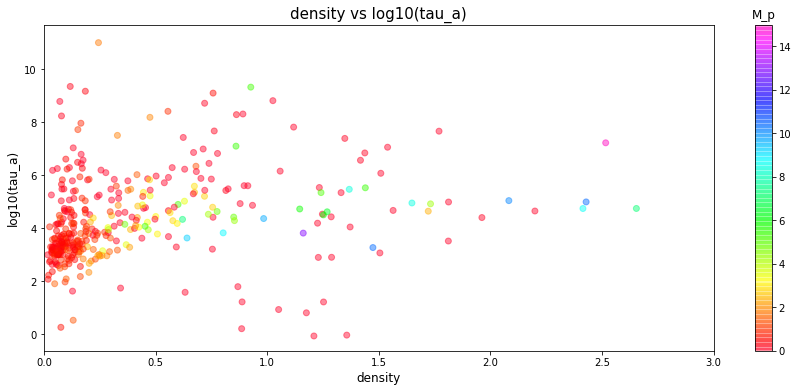

In [77]:
rho = df_new['density']
plt.figure(figsize=(15,6))
map2 = plt.scatter(rho, np.log10(t_omegas), c=df_new[m_p], cmap='gist_rainbow', vmin=0, vmax=15, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.title('density vs log10(tau_a)', fontsize=15)
plt.xlabel('density', fontsize=12)
plt.ylabel('log10(tau_a)', fontsize=12)

plt.xlim(0,3)
#plt.ylim(0,1e15)

(0.0, 1.5)

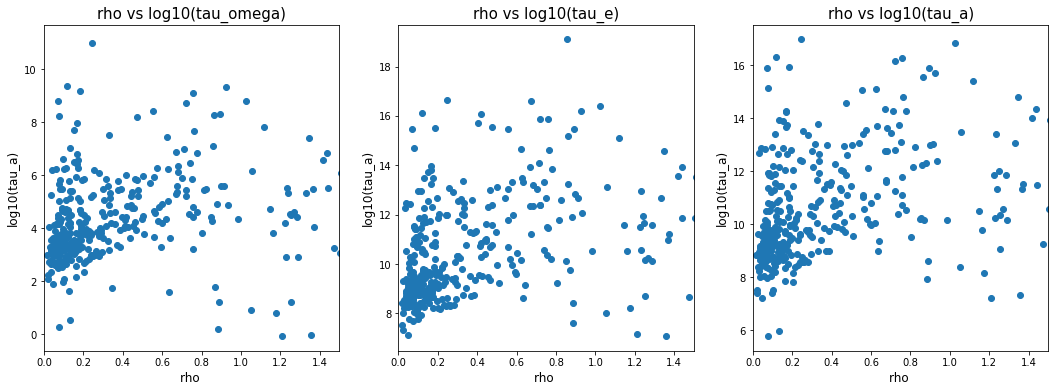

In [78]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
ax1.scatter(rho, np.log10(t_omegas))
ax1.set_title('rho vs log10(tau_omega)', fontsize=15)
ax1.set_xlabel('rho ', fontsize=12)
ax1.set_ylabel('log10(tau_a)', fontsize=12)
ax1.set_xlim(0,1.5)


ax2.scatter(rho, np.log10(t_es))
ax2.set_title('rho vs log10(tau_e)', fontsize=15)
ax2.set_xlabel('rho ', fontsize=12)
ax2.set_ylabel('log10(tau_a)', fontsize=12)
ax2.set_xlim(0,1.5)

ax3.scatter(rho, np.log10(t_as))
ax3.set_title('rho vs log10(tau_a)', fontsize=15)
ax3.set_xlabel('rho ', fontsize=12)
ax3.set_ylabel('log10(tau_a)', fontsize=12)
ax3.set_xlim(0,1.5)


(6.5, 9.0)

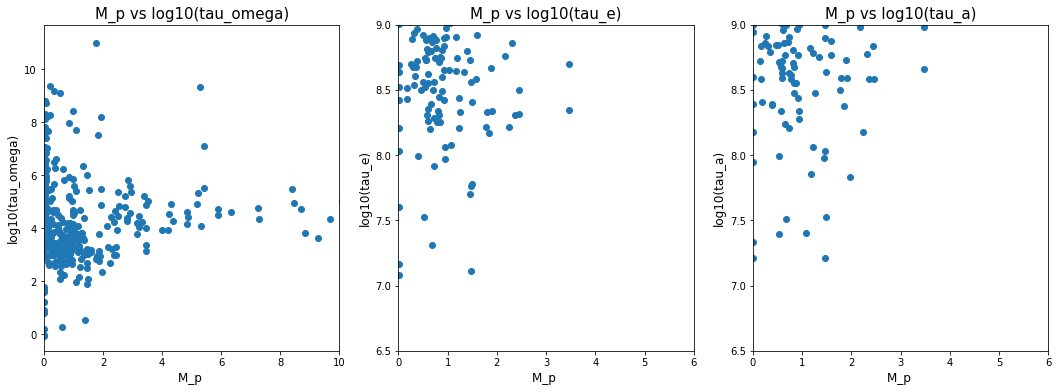

In [79]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
ax1.scatter(df_new[m_p], np.log10(t_omegas))
ax1.set_title('M_p vs log10(tau_omega)', fontsize=15)
ax1.set_xlabel('M_p ', fontsize=12)
ax1.set_ylabel('log10(tau_omega)', fontsize=12)
ax1.set_xlim(0,10)
ax2.set_ylim(0,9)


ax2.scatter(df_new[m_p], np.log10(t_es))
ax2.set_title('M_p vs log10(tau_e)', fontsize=15)
ax2.set_xlabel('M_p ', fontsize=12)
ax2.set_ylabel('log10(tau_e)', fontsize=12)
ax2.set_xlim(0,6)
ax2.set_ylim(6.5,9)

ax3.scatter(df_new[m_p], np.log10(t_as))
ax3.set_title('M_p vs log10(tau_a)', fontsize=15)
ax3.set_xlabel('M_p ', fontsize=12)
ax3.set_ylabel('log10(tau_a)', fontsize=12)
ax3.set_xlim(0,6)
ax3.set_ylim(6.5,9)

# Check the planets with P~6 to 6.5

(array([ 1.,  9., 27., 40., 49., 58., 87., 69., 62., 37., 27., 14.,  8.,
         8.,  4., 11.,  8.,  8.,  7.,  2.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

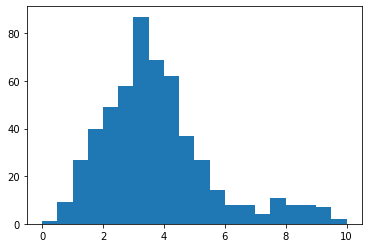

In [80]:
#all
plt.hist(df[p][df[r_p]>0.6],bins=20, range=[0,10])

Text(0.5, 1.0, 'hist_p & r_p>0.6(nasa)')

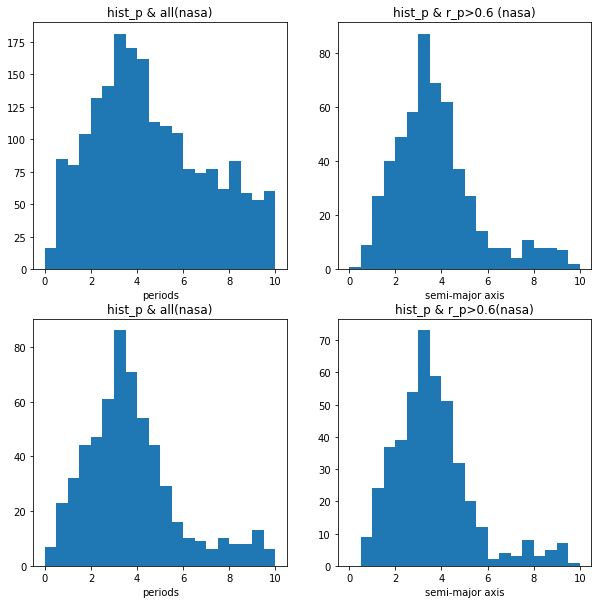

In [35]:
ax1.hist(df_new[p],bins=20, range=[0,10])
ax2.hist(df[p],bins=20, range=[0,10])


fig,axs = plt.subplots(2,2,figsize=(10,10))

axs[0,0].hist(df[p],bins=20, range=[0,10])
axs[0,0].set_xlabel('periods')
axs[0,0].set_title('hist_p & all(nasa)')

axs[0,1].hist(df[p][df[r_p]>0.6],bins=20, range=[0,10])
axs[0,1].set_xlabel('semi-major axis')
axs[0,1].set_title('hist_p & r_p>0.6 (nasa)')

axs[1,0].hist(df_new[p],bins=20, range=[0,10])
axs[1,0].set_xlabel('periods')
axs[1,0].set_title('hist_p & all(nasa)')

axs[1,1].hist(df_new[p][df_new[r_p]>0.6],bins=20, range=[0,10])
axs[1,1].set_xlabel('semi-major axis')
axs[1,1].set_title('hist_p & r_p>0.6(nasa)')

#### comments(528)   
The number of Jupiter like planets are small?

In [15]:
df_exo

name planet_status   mass  mass_error_min  mass_error_max  \
0      11 Com b     Confirmed    NaN             NaN             NaN   
1      11 Oph b     Confirmed  21.00            3.00            3.00   
2      11 UMi b     Confirmed    NaN             NaN             NaN   
3      14 And b     Confirmed    NaN             NaN             NaN   
4      14 Her b     Confirmed    NaN             NaN             NaN   
...         ...           ...    ...             ...             ...   
4718  ups And b     Confirmed   0.62            0.09             inf   
4719  ups And c     Confirmed   9.10            2.93            5.04   
4720  ups And d     Confirmed  23.58            2.29            2.93   
4721  ups And e     Confirmed    NaN             NaN             NaN   
4722  zet Del B     Confirmed  40.00            5.00           15.00   

      mass_sini  mass_sini_error_min  mass_sini_error_max  radius  \
0        19.400                1.500                1.500     NaN   
1           NaN                  NaN                  NaN     NaN   
2        10.500                2.470                2.470     NaN   
3         5.330                0.570                0.570     NaN   
4         4.640                0.190                0.190     NaN   
...         ...                  ...                  ...     ...   
4718      0.620                0.090                0.090     NaN   
4719      1.800                0.260                0.260     NaN   
4720     10.190                  NaN                  NaN     NaN   
4721      1.059                0.028                0.028     NaN   
4722        NaN                  NaN                  NaN     NaN   

      radius_error_min  ...  star_age_error_min  star_age_error_max  \
0                  NaN  ...                 NaN                 NaN   
1                  NaN  ...               0.002               0.002   
2                  NaN  ...               0.540               0.540   
3                  NaN  ...                 NaN                 NaN   
4                  NaN  ...                 NaN                 NaN   
...                ...  ...                 ...                 ...   
4718               NaN  ...               1.000               1.000   
4719               NaN  ...               1.000               1.000   
4720               NaN  ...               1.000               1.000   
4721               NaN  ...               1.000               1.000   
4722               NaN  ...               0.125               0.125   

      star_teff  star_teff_error_min  star_teff_error_max  star_detected_disc  \
0        4742.0                100.0                100.0                 NaN   
1        2375.0                175.0                175.0                 NaN   
2        4340.0                 70.0                 70.0                 NaN   
3        4813.0                 20.0                 20.0                 NaN   
4        5311.0                 87.0                 87.0                 NaN   
...         ...                  ...                  ...                 ...   
4718     6212.0                 80.0                 80.0                 NaN   
4719     6212.0                 80.0                 80.0                 NaN   
4720     6212.0                 80.0                 80.0                 NaN   
4721     6212.0                 80.0                 80.0                 NaN   
4722     8336.0                  NaN                  NaN                 NaN   

      star_magnetic_field                            star_alternate_names  \
0                     NaN                                             NaN   
1                     NaN                          Oph 1622-2405, Oph 11A   
2                     NaN                                             NaN   
3                     NaN                                             NaN   
4                     NaN                                             NaN   
...                   ...    

Text(0.5, 1.0, 'period vs r_p (eu)')

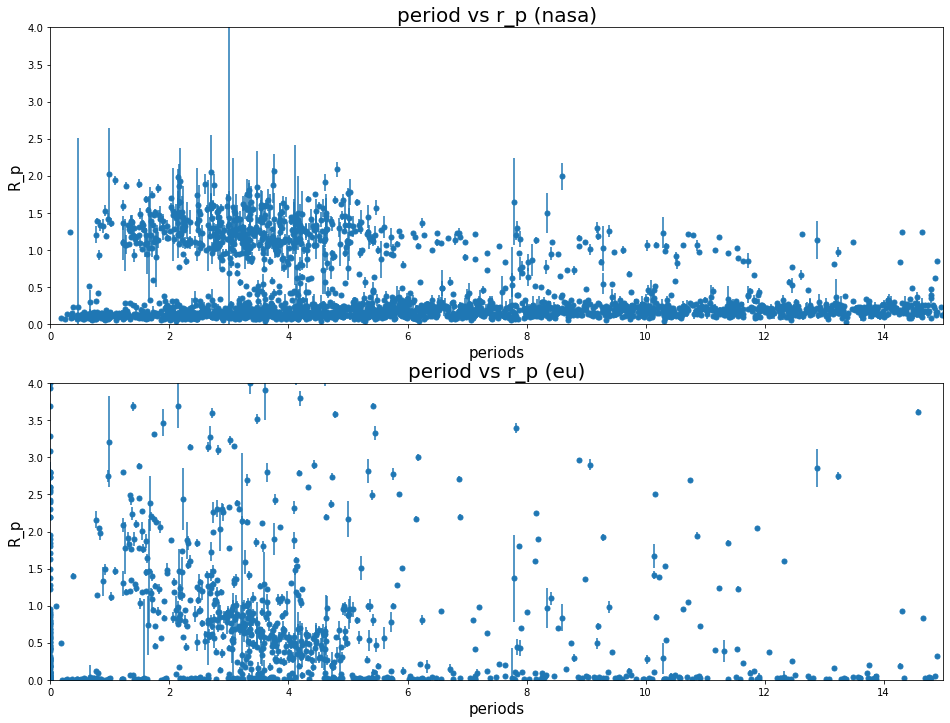

In [302]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,12))

ax1.errorbar(df[p],df[r_p], yerr=df[r_perr1],fmt='o',ms=5.0 )
ax1.set_xlabel('periods',fontsize=15)
ax1.set_ylabel('R_p',fontsize=15)
ax1.set_xlim(0,15)
ax1.set_ylim(0,4)
ax1.set_title('period vs r_p (nasa)', fontsize=20)

ax2.errorbar(df_exo['orbital_period'],df_exo['mass'], yerr=df_exo['radius_error_max'],fmt='o',ms=5.0 )
ax2.set_xlabel('periods',fontsize=15)
ax2.set_ylabel('R_p',fontsize=15)
ax2.set_xlim(0,15)
ax2.set_ylim(0,4)
ax2.set_title('period vs r_p (eu)', fontsize=20)

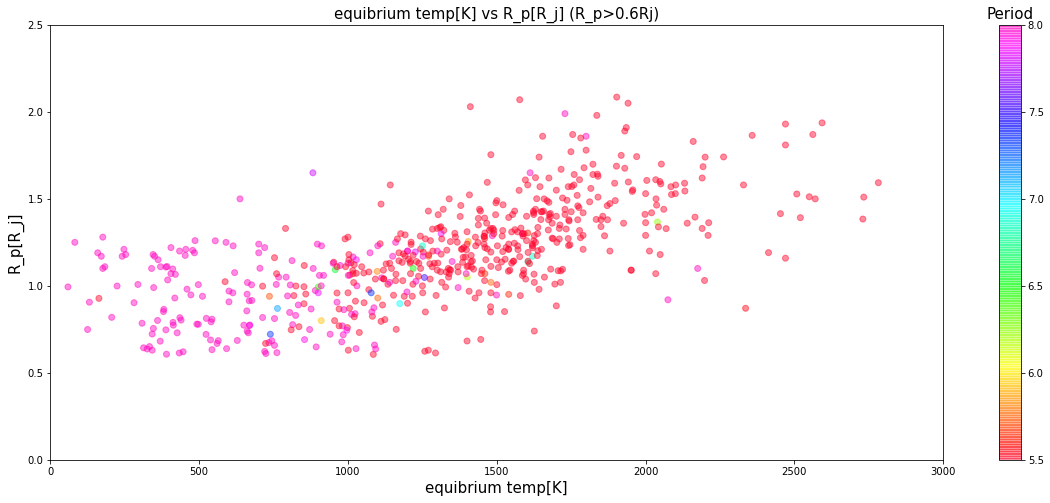

In [5]:
plt.figure(figsize=(20,8))
map2 = plt.scatter(df['pl_eqt'][df[r_p]>0.6],df[r_p][df[r_p]>0.6] , c=df[p][df[r_p]>0.6], cmap='gist_rainbow', vmin=5.5, vmax=8, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('Period',fontsize=15)
plt.title('equibrium temp[K] vs R_p[R_j] (R_p>0.6Rj)', fontsize=15)
plt.xlabel('equibrium temp[K]', fontsize=15)
plt.ylabel('R_p[R_j]', fontsize=15)
plt.xlim(0,3000)
plt.ylim(0,2.5)
#plt.savefig('T(K)vsR_p-c_period.png')

#plt.xlim(0,3)

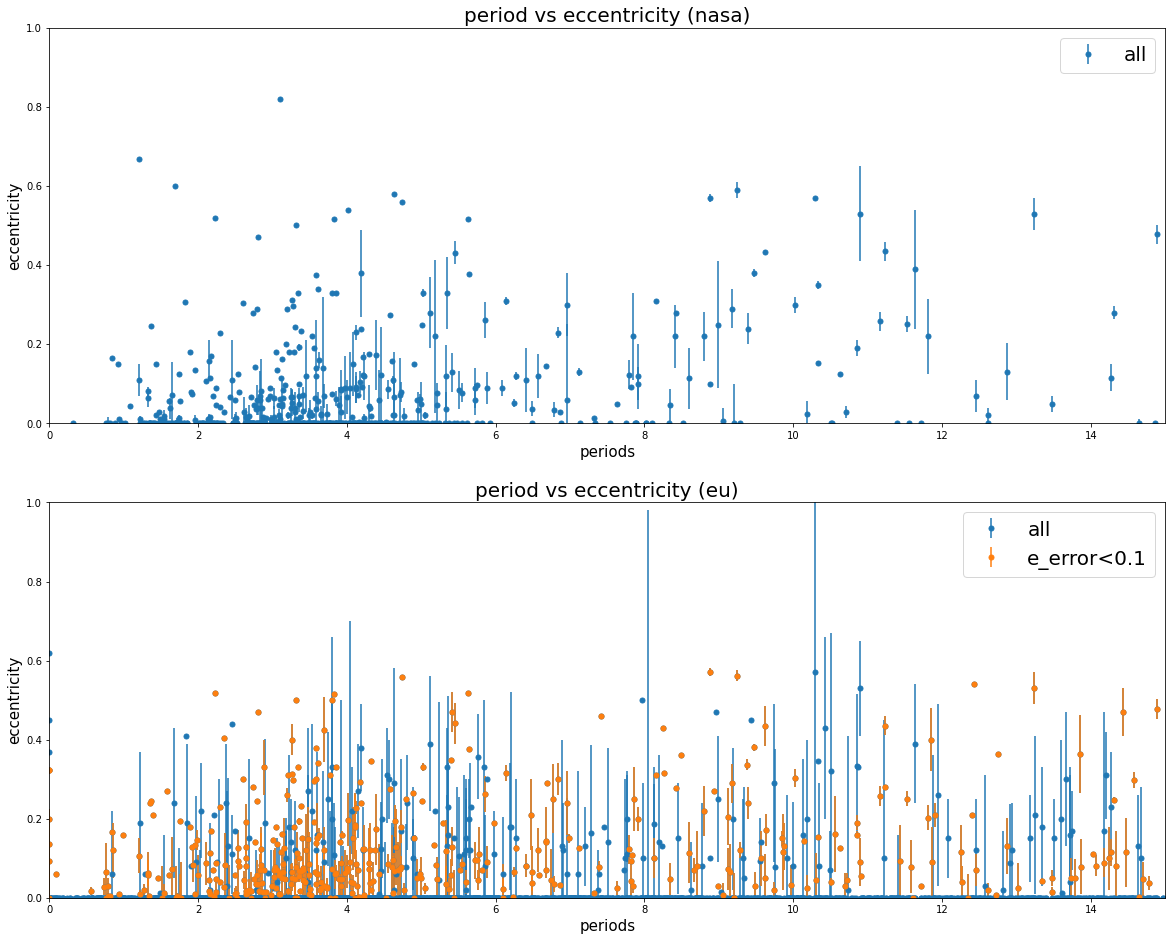

In [297]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,16))

ax1.errorbar(df[p][df[r_p]>0.6],df[e][df[r_p]>0.6], yerr=df[eerr1][df[r_p]>0.6],fmt='o',ms=5.0, label='all' )
#ax1.errorbar(df[p][df[eerr1]<0.1],df[e][df[eerr1]<0.1], yerr=df[eerr1][df[eerr1]<0.1],fmt='o',ms=5.0,label='e_error<0.1' )
ax1.set_xlabel('periods',fontsize=15)
ax1.set_ylabel('eccentricity',fontsize=15)
ax1.set_xlim(0,15)
ax1.set_ylim(0,1)
ax1.set_title('period vs eccentricity (nasa)', fontsize=20)
ax1.legend(fontsize=20)

ax2.errorbar(df_exo['orbital_period'],df_exo['eccentricity'], yerr=df_exo['eccentricity_error_max'],fmt='o',ms=5.0, label='all' )
ax2.errorbar(df_exo['orbital_period'][df_exo['eccentricity_error_max']<0.1],df_exo['eccentricity'][df_exo['eccentricity_error_max']<0.1], yerr=df_exo['eccentricity_error_max'][df_exo['eccentricity_error_max']<0.1],fmt='o',ms=5.0,label='e_error<0.1')
ax2.set_xlabel('periods',fontsize=15)
ax2.set_ylabel('eccentricity',fontsize=15)
ax2.set_xlim(0,15)
ax2.set_ylim(0,1)
ax2.set_title('period vs eccentricity (eu)', fontsize=20)
ax2.legend(fontsize=20)

Text(0.5, 1.0, 'density hist (eu)')

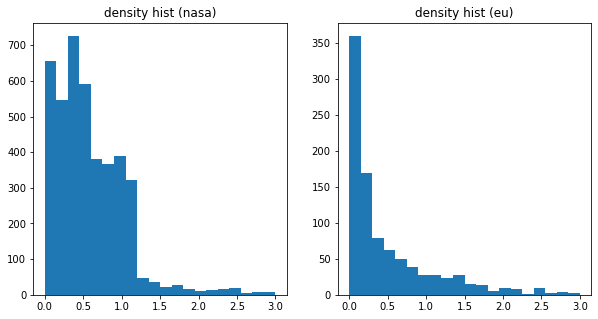

In [152]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.hist(df['density'],bins=20, range=[0,3])
ax1.set_title('density hist (nasa)')
ax2.hist(df_exo['density'],bins=20, range=[0,3])
ax2.set_title('density hist (eu)')

#### comments(528)    
It seems density distribution with NASA archive is not reliable. So I use exoplanet.eu data.

(0.5, 30.0)

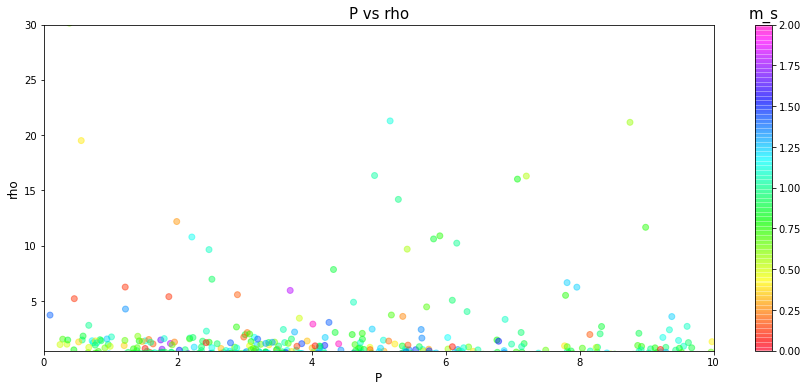

In [172]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_exo['orbital_period'],df_exo['density'], c=df_exo['star_mass'], cmap='gist_rainbow', vmin=0, vmax=2, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('m_s',fontsize=15)
plt.title('P vs rho', fontsize=15)
plt.xlabel('P', fontsize=12)
plt.ylabel('rho', fontsize=12)

plt.xlim(0,10)
plt.ylim(0.5,30)

(array([6., 3., 2., 2., 4., 4., 1., 3., 0., 1.]),
 array([0.13 , 0.297, 0.464, 0.631, 0.798, 0.965, 1.132, 1.299, 1.466,
        1.633, 1.8  ]),
 <BarContainer object of 10 artists>)

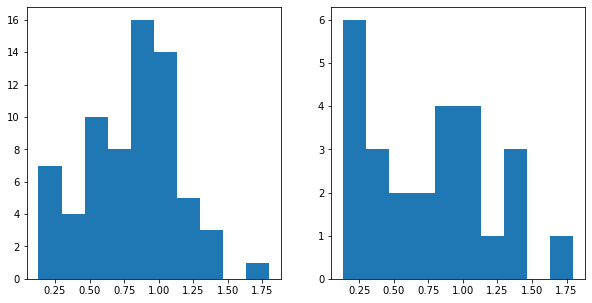

In [218]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.hist(df_exo['star_mass'][(df_exo['density'] > 3.0) & (df_exo['orbital_period']< 15)],bins=10)

ax2.hist(df_exo['star_mass'][(df_exo['density'] > 3.0) & (df_exo['orbital_period']< 5)],bins=10)

#### comments(528)   
Lots of high density planets(p<5days) orbiting around low mass star....? 

(0.1, 5.0)

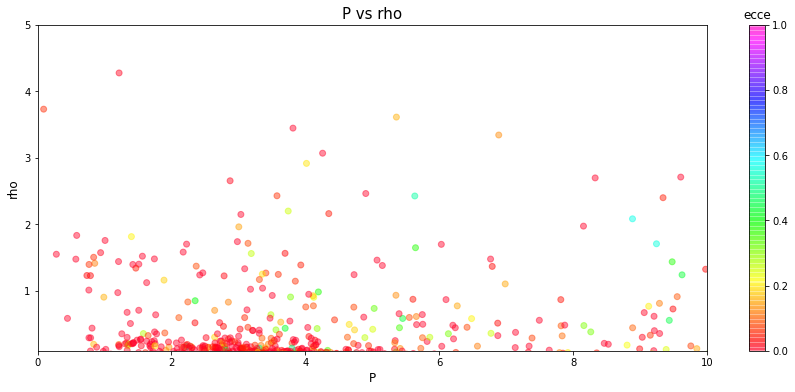

In [179]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_exo['orbital_period'],df_exo['density'], c=df_exo['eccentricity'], cmap='gist_rainbow', vmin=0, vmax=1, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('ecce')
plt.title('P vs rho', fontsize=15)
plt.xlabel('P', fontsize=12)
plt.ylabel('rho', fontsize=12)

plt.xlim(0,10)
plt.ylim(0.1,5)

df[(df['density']>6.0) & (df[r_p]> 1.3)]

Text(0.5, 1.0, 'a vs r_p (eu)')

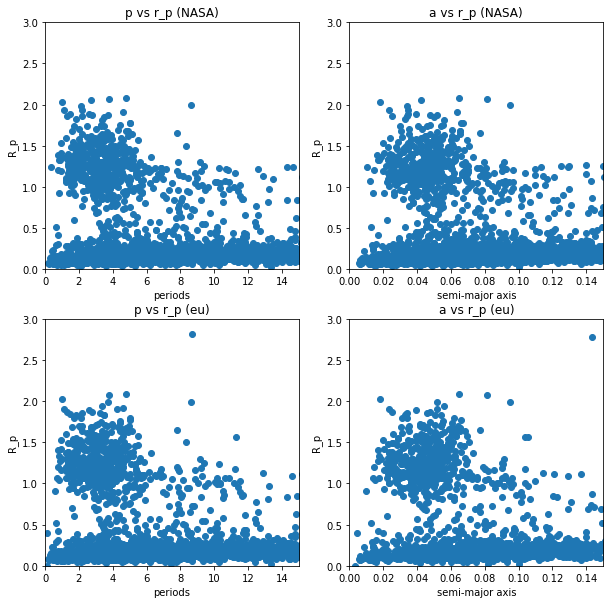

In [17]:
fig,axs = plt.subplots(2,2,figsize=(10,10))

axs[0,0].scatter(df[p],df[r_p])
axs[0,0].set_xlabel('periods')
axs[0,0].set_ylabel('R_p')
axs[0,0].set_xlim(0,15)
axs[0,0].set_ylim(0,3)
axs[0,0].set_title('p vs r_p (NASA)')

axs[0,1].scatter(df[a],df[r_p])
axs[0,1].set_xlabel('semi-major axis')
axs[0,1].set_ylabel('R_p')
axs[0,1].set_xlim(0,0.15)
axs[0,1].set_ylim(0,3)
axs[0,1].set_title('a vs r_p (NASA)')

axs[1,0].scatter(df_exo['orbital_period'],df_exo['radius'])
axs[1,0].set_xlabel('periods')
axs[1,0].set_ylabel('R_p')
axs[1,0].set_xlim(0,15)
axs[1,0].set_ylim(0,3)
axs[1,0].set_title('p vs r_p (eu)')

axs[1,1].scatter(df_exo['semi_major_axis'],df_exo['radius'])
axs[1,1].set_xlabel('semi-major axis')
axs[1,1].set_ylabel('R_p')
axs[1,1].set_xlim(0,0.15)
axs[1,1].set_ylim(0,3)
axs[1,1].set_title('a vs r_p (eu)')

Text(0, 0.5, 'log10(tau_a)')

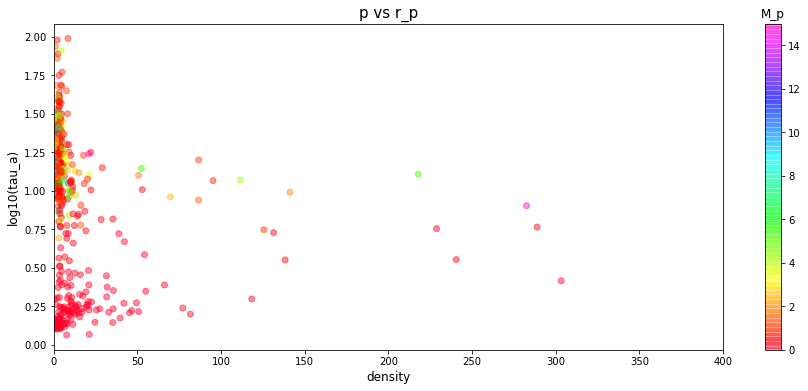

In [85]:
#df_new2['density'] = df_new2[m_p]/(4*np.pi*df_new2[r_p]**3/3)
#rho = df_new2['density']
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_new[p], df_new[r_p], c=df_new[m_p], cmap='gist_rainbow', vmin=0, vmax=15, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.xlim(1e-10,400)
plt.title('p vs r_p', fontsize=15)
plt.xlabel('density', fontsize=12)
plt.ylabel('log10(tau_a)', fontsize=12)

# Plot

## histogram

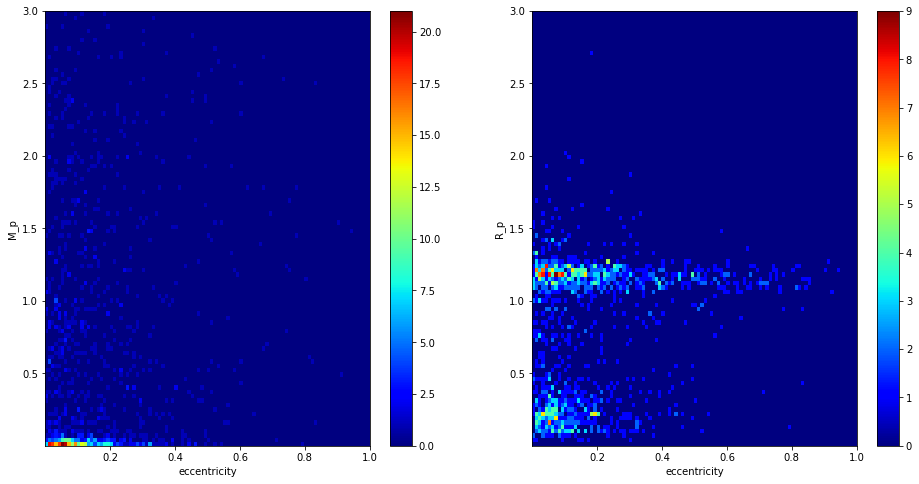

In [29]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
H1 = ax1.hist2d(df[e],df[m_p],bins=100, cmap=cm.jet, range=[[1e-5,1],[1e-5,3]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('eccentricity')
ax1.set_ylabel('M_p')
fig.colorbar(H1[3],ax=ax1)
H2 = ax2.hist2d(df[e],df[r_p],bins=100, cmap=cm.jet, range=[[1e-5,1],[1e-5,3]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity')
ax2.set_ylabel('R_p')
fig.colorbar(H2[3],ax=ax2)

In [30]:
rho = df_hist[m_p][df_hist[m_p]>0.5]/(4*np.pi*df_hist[r_p][df_hist[m_p]>0.5]**3/3)

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,7))

H1 = ax1.hist2d(df_hist[e],df_hist[m_p],bins=100, cmap=cm.jet,cmax=5, range=[[1e-5,1],[1e-5,3]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('eccentricity',fontsize=20)
ax1.set_ylabel('M_p',fontsize=20)
fig.colorbar(H1[3],ax=ax1)

H2 = ax2.hist2d(df_hist[e],df_hist[r_p],bins=100, cmax=5,cmap=cm.jet,range=[[1e-5,1],[1e-5,2.3]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity',fontsize=20)
ax2.set_ylabel('R_p',fontsize=20)
fig.colorbar(H2[3],ax=ax2)

H3 = ax3.hist2d(df_hist[e][df_hist[m_p]>0.5],rho,bins=100, cmap=cm.jet,range=[[1e-5,1],[1e-5,1.5]])
#ax2.set_ylim(0,2)
ax3.set_xlabel('eccentricity',fontsize=20)
ax3.set_ylabel('density',fontsize=20)
fig.colorbar(H3[3],ax=ax3)

In [31]:
plt.hist(df_hist[m_p]/(4*np.pi*df_hist[r_p]**3/3),range=[0.2,3],bins=100)

(array([25., 23., 16., 18., 13., 11., 10.,  9.,  7., 12.,  7.,  6.,  8.,
         6.,  6.,  8.,  6.,  4.,  7.,  9.,  7.,  3.,  3.,  7.,  7.,  3.,
         2.,  2.,  3.,  5.,  4.,  2.,  1.,  2.,  3.,  1.,  6.,  5.,  4.,
         2.,  3.,  5.,  2.,  2.,  2.,  3.,  2.,  1.,  2.,  1.,  1.,  1.,
         0.,  2.,  2.,  2.,  1.,  3.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.]),
 array([0.2  , 0.228, 0.256, 0.284, 0.312, 0.34 , 0.368, 0.396, 0.424,
        0.452, 0.48 , 0.508, 0.536, 0.564, 0.592, 0.62 , 0.648, 0.676,
        0.704, 0.732, 0.76 , 0.788, 0.816, 0.844, 0.872, 0.9  , 0.928,
        0.956, 0.984, 1.012, 1.04 , 1.068, 1.096, 1.124, 1.152, 1.18 ,
        1.208, 1.236, 1.264, 1.292, 1.32 , 1.348, 1.376, 1.404, 1.432,
        1.46 , 1.488, 1.516, 1.544, 1.572, 1.6  , 1.628, 1.656, 1.684,
        

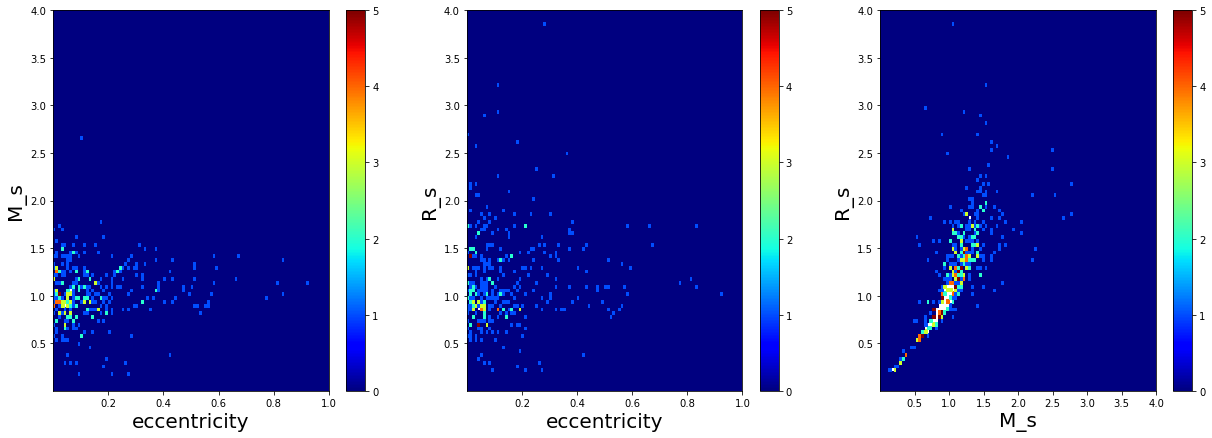

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,7))
H1 = ax1.hist2d(df_hist[e],df_hist[m_s],bins=100, cmap=cm.jet, cmax=5,range=[[1e-5,1],[1e-5,4]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('eccentricity',fontsize=20)
ax1.set_ylabel('M_s',fontsize=20)
fig.colorbar(H1[3],ax=ax1)
H2 = ax2.hist2d(df_hist[e],df_hist[r_s],bins=100, cmap=cm.jet,cmax=5,range=[[1e-5,1],[1e-5,4]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity',fontsize=20)
ax2.set_ylabel('R_s',fontsize=20)
fig.colorbar(H2[3],ax=ax2)
H3 = ax3.hist2d(df_hist[m_s],df_hist[r_s],bins=100, cmap=cm.jet,cmax=5, range=[[1e-5,4],[1e-5,4]])
#ax2.set_ylim(0,2)
ax3.set_xlabel('M_s',fontsize=20)
ax3.set_ylabel('R_s',fontsize=20)
fig.colorbar(H3[3],ax=ax3)

In [33]:
rho2 = df_hist[m_p][df_hist[r_p]>0.5]/(4*np.pi*df_hist[r_p][df_hist[r_p]>0.5]**3/3)
plt.scatter(df_hist[a][df_hist[r_p]>0.5],rho2)
plt.xlim(1e-4,0.05)
plt.ylim(1e-4,0.2)
plt.xlabel('semi-major axis')
plt.ylabel('density')

Text(0, 0.5, 'density')

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,10))
H1 = ax1.hist2d(df_hist[r_p],df_hist[p],bins=80, cmap=cm.jet,range=[[1e-5,3],[5,9]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('r_p',fontsize=20)
ax1.set_ylabel('Periods',fontsize=20)
fig.colorbar(H1[3],ax=ax1)
H2 = ax2.hist2d(df_hist[e],df_hist[p],bins=80, cmap=cm.viridis,range=[[0,0.4],[5,9]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity',fontsize=20)
ax2.set_ylabel('period',fontsize=20)
fig.colorbar(H2[3],ax=ax2)
H3 = ax3.hist2d(df_hist[e],df_hist[a],bins=100, cmap=cm.jet,cmax=5, range=[[1e-5,1],[1e-5,1]])
#ax2.set_ylim(0,2)
ax3.set_xlabel('eccentricity',fontsize=20)
ax3.set_ylabel('semi-major axis',fontsize=20)
fig.colorbar(H3[3],ax=ax3)

# previous cells

## Previous functions

#Definitions

#fixed parameters
Epsilon_p = 1
Epsilon_s = 1e-2
alpha_p = 0.26
alpha_s = 0.07

#Q_dash_p = 1e4
#Q_dash_s = 1e8
#array_dQ = np.arange(1e4, 1e6, 1e4)
#array_domega = np.empty(len(array_dQ))


#Gu - eq(5)
def omega_dot(params,Q_dash_p,Q_dash_s,Omega0_p, Omega0_s):
    #parameters of planetary system
    M_p,M_s,R_p,R_s,a,p,e = params
    #M_p: planet mass in M_jup
    #M_s: stellar mass in M_sun
    #R_p: planetary radius in R_jupa
    #a: semi-major axis [au]
    #p: orbital periods [days]
    #e: eccentricitay
    
    #Omega0: angular rotation velocity [day]
    
    #change the unit
    M_p = M_p * M_jup
    M_s = M_s * M_sun
    M_t = M_p + M_s
    R_s = R_s * R_sun
    R_p = R_p * R_jup
    a = a * au
    #p = p * 24 * 60**2
    #Omega0 = Omega0 * 24 * 60**2

    #Omega = 2 * np.pi/ p
    
    #n = np.sqrt(G*M_t/a**3)
    n = 2 * np.pi / p
    Omega_p = 2 * np.pi / Omega0_p 
    Omega_s = 2 * np.pi / Omega0_p 
    
    f3 = (1 + (15*e**2)/2 + (45*e**4)/8 + (5*e**6)/16) * (1 - e**2)**(-6)
    f4 = (1 + 3*e**2 + (3*e**4)/8) * (1 - e**2)**(-9/2)
    
    
    omega_dot_p = (M_s**2/(alpha_p*Epsilon_p*M_p*M_t)) * (9*n/(2*Q_dash_p)) * (R_p/a)**3 * (f3*n - f4*Omega_p)
    omega_dot_s = (M_p**2/(alpha_s*Epsilon_s*M_s*M_t)) * (9*n/(2*Q_dash_s)) * (R_s/a)**3 * (f3*n - f4*Omega_s)
    
    return omega_dot_p, omega_dot_s

#Gu - eq(17)
def tau_omega_e0(params,Q_dash_p,Omega0):
    M_p,M_s,R_p,R_s,a,p,e = params
    
    #M_p = M_p * M_jup
    #M_s = M_s * M_sun
    #M_t = M_p + M_s
    #R_p = R_p * R_jup
    #a = a * au

    n = 2 * np.pi / p
    #Omega = 2 * np.pi / Omega0
    
    domega_e0 = (0.187*alpha_p*Epsilon_p) * abs((1/Omega0)/(0.34*np.sqrt(M_s) * (0.04/a)**(3/2) - (1/Omega0))) \
            * (Q_dash_p/1e6) *  M_p * (1/M_s)**(3/2) * (a/0.04)**(9/2) * (1/R_p)**3
    
    return domega_e0

#Gu - eq(6)
def _J_dot(params,Omega0_p,Omega0_s,Q_dash_p,Q_dash_s):
    
    M_p,M_s,R_p,R_s,a,p,e = params
    
    M_p = M_p * M_jup
    M_s = M_s * M_sun
    M_t = M_p + M_s
    R_p = R_p * R_jup
    R_s = R_s * R_sun
    a = a * au
    
    n = 2 * np.pi / p
    Omega_p = 2 * np.pi / Omega0_p 
    Omega_s = 2 * np.pi / Omega0_p 
    J0 = M_p * np.sqrt(G*M_t*a*(1-e**2))
    
    f3 = (1 + (15*e**2)/2 + (45*e**4)/8 + (5*e**6)/16) * (1 - e**2)**(-6)
    f4 = (1 + 3*e**2 + (3*e**4)/8) * (1 - e**2)**(-9/2)
    
    #J_dot_p = (-1*alpha*Epsilon*J0*M_p/(np.sqrt(1-e**2)*M_p)) * (R_p/a)**2 * (omega_dot_p/n)
    J_dot_p = (9*J0*M_s**2/(M_p*M_t)) * (f4*Omega_p - f3*n)/(2*Q_dash_p*np.sqrt(1-e**2)) * (R_p/a)**5
    
    J_dot_s = (9*J0*M_p**2/(M_p*M_t)) * (f4*Omega_s - f3*n)/(2*Q_dash_s*np.sqrt(1-e**2)) * (R_s/a)**5
    
    return J0,J_dot_p,J_dot_s

#Gu - eq(12)
def _e_dot(params,Omega0_p,Omega0_s,Q_dash_p,Q_dash_s):

    M_p,M_s,R_p,R_s,a,p,e = params
    
    M_p = M_p * M_jup
    M_s = M_s * M_sun
    M_t = M_p + M_s
    R_p = R_p * R_jup
    R_s = R_s * R_sun
    a = a * au
    
    Omega_p = 2 * np.pi / Omega0_p 
    Omega_s = 2 * np.pi / Omega0_p 
    
    n = 2 * np.pi / p

    f1 = (1 + 15/4*e**2 + 15/8*e**4 + 5/64*e**6) * (1-e**2)**(13/2)
    f2 = (1 + 3/2*e**2 + e**4/8) * (1-e**2)**5
    
    g_p = (-81*e/(2*Q_dash_p)) * (M_s/M_p) * (R_p/a)**5 * (f1*n - 11*f2*Omega_p/18)
    g_s = (-81*e/(2*Q_dash_s)) * (M_p/M_s) * (R_s/a)**5 * (f1*n - 11*f2*Omega_s/18)
    
    e_dot = g_p + g_s
    
    return e_dot, e/abs(e_dot)
                  
           
#Gu - eq(20)

def _tau_a(e, a, J0, J_dot_p, J_dot_s, e_dot):
    a_dot = a * (2*e*e_dot/(1-e**2) + 2*(J_dot_p+J_dot_s)/J0)
    a_a_dot = (2*e*e_dot/(1-e**2) + 2*(J_dot_p+J_dot_s)/J0)**(-1)
    tau_a = a / abs(a_dot)
    return a_dot, a_a_dot, tau_a



'''
Omega_ps: the rotational angular freq. at pseudo-synchronization
n: orbital angular velocity/ (=2pi/orbital period)
n_p: orbital angular velocity at periastron
'''

#Hut-eq(42): Omega_ps/n
def _omega_ps_n(e):
    ratio = (1 + 15*e**2/2 + 45*e**4/8 + 5*e**6/16)/((1 + 3*e**2 + 3*e**4/8)*(1-e**2)**(3/2)) 
    return ratio

#Hut - eq(44): n_p
def _n_p(e,P_orb):
    n = 2*np.pi/P_orb
    n_p = (1 + e)**2 * n / (1 - e**2)**(3/2)
    return n_p

#Hut - eq(45): Omega_ps/n_p
def _omega_ps_n_p(e):
    ratio = (1 + 15*e**2/2 + 45*e**4/8 + 5*e**6/16)/((1 + 3*e**2 + 3*e**4/8)*(1+e)**2)
    return ratio



## Target List (both transit and RV obs.)

In [9]:
'''
#single star/ puffy
print(df_new.loc[3546])
print(df_new.loc[3870])
#single star/ 2 planets/ outer planet 3Mj
print(df_new.loc[768])
#single star system
print(df_new.loc[961])
#binary
print(df_new.loc[752])
print(df_new.loc[3456])
'''
loc_array = np.array([3546,3870,768,961,752,3456])

### Jupiter

In [21]:
P_s = 25

M_p = 1
M_s = 1
R_p = 1
R_s = 1
a0 = 5.2
p0 = 4332
e0 = 0.0489
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

[1, 1, 1, 1, 5.2, 4332, 0.0489]


In [105]:
for i in range(len(array_rot_p)):
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')


Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

omega_ps/n =  1.014349698739907
omega_ps/n_p =  0.918670846196364
n_p =  0.001601471412578398
omega_ps =  4270.716504753243


In [106]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 6.545e+22

a_a_dot =  -1.365359198214442e+25
tau_a = 1.365e+25



### HD 221416   
[Huber2019](https://iopscience.iop.org/article/10.3847/1538-3881/ab1488)   
V sini = 2.8 ± 1.6[km/s]   
M_s = 1.212 ± 0.074   
R_s = 2.943 ± 0.064 R_sun   

In [56]:
df.loc[df[name]=='HD 221416']

rowid      pl_name   hostname pl_letter    hd_name    hip_name  \
742    743  HD 221416 b  HD 221416         b  HD 221416  HIP 116158   

            tic_id                       gaia_id  sy_snum  sy_pnum  ...  \
742  TIC 441462736  Gaia DR2 2388463203438164096        1        1  ...   

     sy_kepmag  sy_kepmagerr1 sy_kepmagerr2  \
742        NaN            NaN           NaN   

                                     sy_kepmag_reflink pl_nnotes st_nphot  \
742  <a refstr=STASSUN_ET_AL__2019 href=https://ui....       0.0      1.0   

    st_nrvc st_nspec pl_nespec pl_ntranspec  
742     0.0      0.0       0.0          0.0  

[1 rows x 313 columns]

In [7]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 2.943 * R_sun/(2.8 * 1e3) / (60**2 * 24)

In [58]:
ind = 742
#ind = loc_array[0]
M_p = df_new.loc[ind][m_p]
M_s = df_new.loc[ind][m_s]
R_p = df_new.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
a0 = df_new.loc[ind][a]
p0 = df_new.loc[ind][p]
e0 = df_new.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

[0.19, 1.21, 0.836, 2.94, 0.1228, 14.2767, 0.115]


In [59]:
t_omega, t_e, t_a = timescale(params, 0.5, 3)

print('tau_omega = {:.3e}\n'.format(t_omega))
print('tau_e = {:.3e}\n'.format(t_e))
print('tau_a = {:.3e}\n'.format(t_a))

tau_omega = 1.032e+05

tau_e = 1.021e+11

tau_a = 2.220e+11



omega_ps/n =  1.079464584322544
omega_ps/n_p =  0.8511103477654943
n_p =  0.5581803739984871
omega_ps =  13.225723388562898


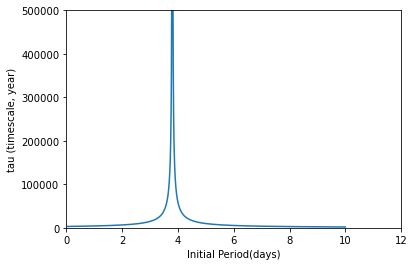

In [60]:
'''
for i in range(len(array_rot_p)):
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
'''
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,12)
plt.ylim(0,5e5)

plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')


Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

In [61]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

NameError: name 'Q_dash_p' is not defined

In [26]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 0.96 * R_sun/( 3.5 * 1e3) / (60**2 * 24)
#P_s = 4.0

In [16]:
ind = 784
print(df_all.loc[ind][name])
M_p = df_all.loc[ind][m_p]
M_s = df_all.loc[ind][m_s]
R_p = df_all.loc[ind][r_p]
R_s = df_all.loc[ind][r_s]
a0 = df_all.loc[ind][a]
p0 = df_all.loc[ind][p]
e0 = df_all.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

KeyError: 'pl_hostname'

omega_ps/n =  1.1063678077450874
omega_ps/n_p =  0.8390990353105605
n_p =  0.08695566975314281
omega_ps =  86.11300449366591


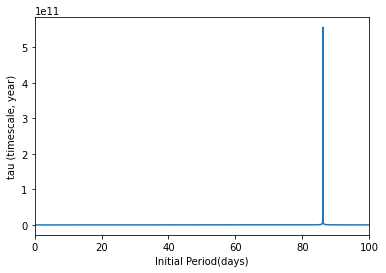

In [30]:
for i in range(len(array_rot_p)):
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,100)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

In [37]:
plt.plot(array_rot_p, array_tau_omega)
plt.ylim(0,5e7)
plt.xlim(0,20)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Text(0, 0.5, 'tau (timescale, year)')

### HD 1397   
V sin i = 3.0 ± 0.3[km/s]   
R_s = 2.341 ± 0.022[km/s]

In [103]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 2.341 * R_sun/(3.0 * 1e3) / (60**2 * 24)

In [104]:
ind = loc_array[1]
print(df_new.loc[ind][name])
M_p = df_new.loc[ind][m_p]
M_s = df_new.loc[ind][m_s]
R_p = df_new.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
a0 = df_new.loc[ind][a]
p0 = df_new.loc[ind][p]
e0 = df_new.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

NameError: name 'loc_array' is not defined

omega_ps/n =  1.3844607881180995
omega_ps/n_p =  0.8023700907522479
n_p =  0.9398440004580719
omega_ps =  8.332001959896601


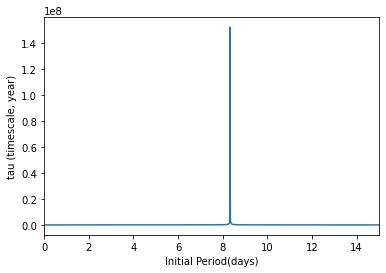

In [23]:
for i in range(len(array_rot_p)):
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

In [24]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 5.237e+11

a_a_dot =  -3894346330871.4517
tau_a = 3.894e+12



### HAT-P-17   
[reference](https://iopscience.iop.org/article/10.1088/0004-637X/749/2/134)   
V sini = 0.3 ± 0.5[km/s]      
M_s = 0.857 ± 0.039   
R_s = 0.838 ± 0.021R_sun  

In [25]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 0.838 * R_sun/(0.3 * 1e3) / (60**2 * 24)

In [26]:
#ind = 4272 
ind = loc_array[2]
print(df_new.loc[ind][name])
M_p = df_new.loc[ind][m_p]
M_s = df_new.loc[ind][m_s]
R_p = df_new.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
#a0 = df_new.loc[ind][a]
a0 = 0.0882
p0 = df_new.loc[ind][p]
e0 = df_new.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

HAT-P-17
[0.58, 0.99, 1.05, 0.87, 0.0882, 10.33852, 0.35]


omega_ps/n =  1.7752466319864852
omega_ps/n_p =  0.8006852868024903
n_p =  1.3474676436777957
omega_ps =  5.82370911946544


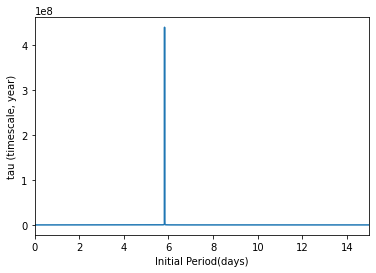

In [28]:
for i in range(len(array_rot_p)):
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

In [29]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 1.156e+12

a_a_dot =  4139051467953.879
tau_a = 4.139e+12



### HD 17156   
[reference](https://www.aanda.org/articles/aa/pdf/2008/27/aa9238-07.pdf)   
V sini = 2.8[km/s]   
R_s = 1.63 ± 0.171R_sun 

In [30]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 1.63 * R_sun/(2.8 * 1e3) / (60**2 * 24)

In [31]:
#ind = 4272 
ind = loc_array[3]
print(df_new.loc[ind][name])
M_p = df_new.loc[ind][m_p]
M_s = df_new.loc[ind][m_s]
R_p = df_new.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
a0 = 0.1623
#a0 = df_new.loc[ind][a]
p0 = df_new.loc[ind][p]
e0 = df_new.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

HD 17156
[3.51, 1.41, 1.1, 1.55, 0.1623, 21.21663, 0.68]


In [33]:
for i in range(len(array_rot_p)):
    #the last value shows rotation period of a host star
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

omega_ps/n =  5.8623490378207475
omega_ps/n_p =  0.8187324408705553
n_p =  2.120474914281924
omega_ps =  3.6191345590516066


In [34]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 2.513e+13

a_a_dot =  14606953502257.316
tau_a = 1.461e+13



### HD80606
[reference](https://arxiv.org/abs/astro-ph/0106256)   
V sini = 0.9 ± 0.6[km/s]   


In [35]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 0.98 * R_sun/(0.9 * 1e3) / (60**2 * 24)

In [36]:
#ind = 4272 
ind = loc_array[4]
print(df_new.loc[ind][name])
M_p = df_new.loc[ind][m_p]
M_s = df_new.loc[ind][m_s]
R_p = df_new.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
#a0 = df_new.loc[ind][a]
a0 = 0.449
p0 = df_new.loc[ind][p]
e0 = df_new.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

HD 80606
[4.38, 1.15, 1.07, 1.04, 0.449, 111.4367, 0.93]


omega_ps/n =  61.822727948026014
omega_ps/n_p =  0.824169559743461
n_p =  4.229443425822248
omega_ps =  1.802519942078327


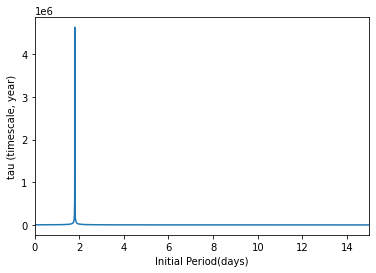

In [38]:
for i in range(len(array_rot_p)):
    #the last value shows rotation period of a host star
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

In [39]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 2.051e+18

a_a_dot =  1.6014768301539216e+17
tau_a = 1.601e+17



### WASP-8   
[reference](https://www.aanda.org/articles/aa/full_html/2017/03/aa29973-16/aa29973-16.html)   
V sini = 1.9 ± 0.05[km/s]   
R_s = 0.945 ± 0.171R_sun 

In [40]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 0.945 * R_sun/(1.9 * 1e3) / (60**2 * 24)

In [41]:
#ind = 4272 
ind = loc_array[5]
print(df_new.loc[ind][name])
M_p = df_new.loc[ind][m_p]
M_s = df_new.loc[ind][m_s]
R_p = df_new.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
#a0 = df_new.loc[ind][a]
a0 = 0.449
p0 = df_new.loc[ind][p]
e0 = df_new.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

WASP-8
[2.54, 1.34, 1.13, 1.03, 0.449, 8.15872, 0.31]


omega_ps/n =  1.5971261522652664
omega_ps/n_p =  0.799792282981296
n_p =  1.537870801264431
omega_ps =  5.108375433229346


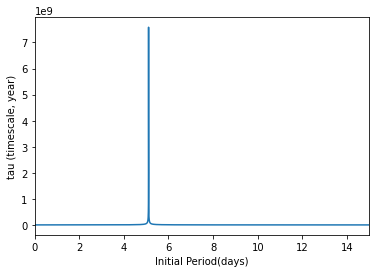

In [42]:
for i in range(len(array_rot_p)):
    #the last value shows rotation period of a host star
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

In [43]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 5.774e+15

a_a_dot =  -2.7154492100114064e+16
tau_a = 2.715e+16



### WASP-19 (e=0)   
V sini = 4.0 ± 2.0[km/s]   
R_s = 0.96 R_sun 

In [45]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 0.96 * R_sun/(4.0 * 1e3) / (60**2 * 24)

In [44]:
df_new.loc[df[name]=='HD 1397']

pl_hostname  pl_orbeccen  st_mass  pl_bmassj  pl_orbsmax   st_spstr  \
3870     HD 1397        0.251     1.32      0.415      0.1097  G5 III/IV   

      st_dist  pl_pnum  st_rad  pl_radj  pl_orbper  st_vsini  pl_tranflag  \
3870    79.75        1    2.34    1.026   11.53533       2.0            1   

      pl_rvflag        ra       dec  pl_cbflag  
3870          1  4.446472 -66.35891          0

In [46]:
ind = 2350
M_p = df.loc[ind][m_p]
M_s = df.loc[ind][m_s]
R_p = df.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
a0 = df.loc[ind][a]
p0 = df.loc[ind][p]
e0 = 0.0
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

[1.069, 0.9, 1.392, 1.0, 0.01634, 0.78883899, 0.0]


omega_ps/n =  1.0
omega_ps/n_p =  1.0
n_p =  7.965104903320747
omega_ps =  0.78883899


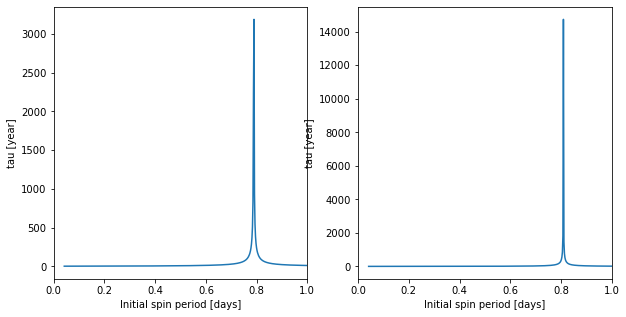

In [47]:
for i in range(len(array_rot_p)):
    #the last value shows rotation period of a host star
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    array_tau_e0[i] = tau_omega_e0(params,Q_dash_p,array_rot_p[i])
    


fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(array_rot_p,array_tau_omega)
ax1.set_xlim(0,1)
ax1.set_xlabel('Initial spin period [days]')
ax1.set_ylabel('tau [year]')
ax2.plot(array_rot_p,array_tau_e0*1e6)
ax2.set_xlim(0,1)
ax2.set_xlabel('Initial spin period [days]')
ax2.set_ylabel('tau [year]')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

### HATS-69

In [48]:
#Stellar Rotation Period [day]
P_s = 2 * np.pi * 0.8785 * R_sun/(2.55 * 1e3) / (60**2 * 24)

In [49]:
df_new.loc[df[name]=='HATS-69']

pl_hostname  pl_orbeccen  st_mass  pl_bmassj  pl_orbsmax st_spstr  \
4272     HATS-69        0.519     0.89      0.577     0.03211        0   

      st_dist  pl_pnum  st_rad  pl_radj  pl_orbper  st_vsini  pl_tranflag  \
4272    420.3        1    0.88    0.945   2.225258      2.55            1   

      pl_rvflag         ra        dec  pl_cbflag  
4272          1  289.29735 -60.891683          0

In [50]:
ind = 4272
M_p = df_new.loc[ind][m_p]
M_s = df_new.loc[ind][m_s]
R_p = df_new.loc[ind][r_p]
R_s = df_new.loc[ind][r_s]
a0 = df_new.loc[ind][a]
p0 = df_new.loc[ind][p]
e0 = df_new.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

[0.577, 0.89, 0.945, 0.88, 0.03211, 2.2252577, 0.519]


In [51]:

for i in range(len(array_rot_p)):
    #the last value shows rotation period of a host star
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,2.5)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

omega_ps/n =  2.9963773044164563
omega_ps/n_p =  0.811026839292546
n_p =  10.43183785887637
omega_ps =  0.7426493641905915


In [52]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 3.790e+08

a_a_dot =  513969517.4226204
tau_a = 5.140e+08



### TOI-573 b (Planet Candidate)   
TIC ID = 296780789   
distance = 88pc

In [53]:
P_s = 50

M_p = 365.50267 * M_earth/M_jup
M_s = 0.22
R_p = 12.890328 * R_earth/R_jup
R_s = 0.338
a0 = 0.0684
p0 = 13.57708
e0 = 0.25
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

[<Quantity 1.15000001>, 0.22, <Quantity 1.15000001>, 0.338, 0.0684, 13.57708, 0.25]


In [55]:
for i in range(len(array_rot_p)):
    #the last value shows rotation period of a host star
    array_omega_dot[i] = omega_dot(params,Q_dash_p,Q_dash_s,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

omega_ps/n =  1.3813163437200486
omega_ps/n_p =  0.8024722792607802
n_p =  0.7965932146379264
omega_ps =  9.829088073652494


In [56]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = 5.396e+11

a_a_dot =  -4046943692001.0483
tau_a = 4.047e+12



### HATS-71 (d=140pc)

In [22]:
df.loc[df[name]=='HATS-71']

rowid    pl_name hostname pl_letter hd_name hip_name         tic_id  \
389    390  HATS-71 b  HATS-71         b     NaN      NaN  TIC 234523599   

                          gaia_id  sy_snum  sy_pnum  ...  sy_kepmag  \
389  Gaia DR2 4710594412266148352        1        1  ...        NaN   

     sy_kepmagerr1 sy_kepmagerr2  \
389            NaN           NaN   

                                     sy_kepmag_reflink pl_nnotes st_nphot  \
389  <a refstr=STASSUN_ET_AL__2019 href=https://ui....       0.0      0.0   

    st_nrvc st_nspec pl_nespec pl_ntranspec  
389     0.0      0.0       0.0          0.0  

[1 rows x 313 columns]

In [50]:
ind = 389
M_p = df.loc[ind][m_p]
M_s = df.loc[ind][m_s]
R_p = df.loc[ind][r_p]
R_s = df.loc[ind][r_s]
a0 = df.loc[ind][a]
p0 = df.loc[ind][p]
e0 = df.loc[ind][e]
params = [M_p,M_s,R_p,R_s,a0,p0,e0]
print(params)

[0.37, 0.49, 1.024, 0.48, 0.03745, 3.7955202, 0.0]


In [45]:
for i in range(len(array_rot_p)):
    #the last value shows rotation period of a host star
    array_omega_dot[i] = omega_dot(params,1e5,1e6,array_rot_p[i],P_s)[0]
    array_tau_omega[i] = (2*np.pi/((array_rot_p[i]))/abs(array_omega_dot[i]))/365
    #array_tau_e0[i] = tau_e0(params,Q_dash,array_rot_p[i])
    
#tau_
#tau_a = _tau_a(e0,)


plt.plot(array_rot_p, array_tau_omega)
plt.xlim(0,15)
plt.xlabel('Initial Period(days)')
plt.ylabel('tau (timescale, year)')

Omega_ps_n = _omega_ps_n(e0)
print('omega_ps/n = ',Omega_ps_n)
Omega_ps_n_p = _omega_ps_n_p(e0)
print('omega_ps/n_p = ',Omega_ps_n_p)
n_p = _n_p(e0,p0)
print('n_p = ',n_p)
p_ps = 2 * np.pi/(Omega_ps_n_p * n_p)
print('omega_ps = ',p_ps)

omega_ps/n =  1.0
omega_ps/n_p =  1.0
n_p =  1.6554301955419803
omega_ps =  3.7955


In [59]:
e_dot = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[0]
tau_e = _e_dot(params, p_ps, P_s,Q_dash_p,Q_dash_s)[1]
print('tau_e = {:.3e}\n'.format(tau_e))

J0 = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[0]
J_p = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[1]
J_s = _J_dot(params, p_ps, P_s, Q_dash_p, Q_dash_s)[2]
'''
print('J0',J0)
print('Jp',J_p)
print('Js',J_s)
'''

a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[0]
a_a_dot = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[1]
tau_a = _tau_a(e0,a0,J0,J_p,J_s,e_dot)[2]
print('a_a_dot = ', a_a_dot)
print('tau_a = {:.3e}\n'.format(tau_a))

tau_e = nan

a_a_dot =  inf
tau_a = inf



/home/yterada/anaconda3/envs/highe/lib/python3.9/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/yterada/anaconda3/envs/highe/lib/python3.9/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in reciprocal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/yterada/anaconda3/envs/highe/lib/python3.9/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## plot

### histogram

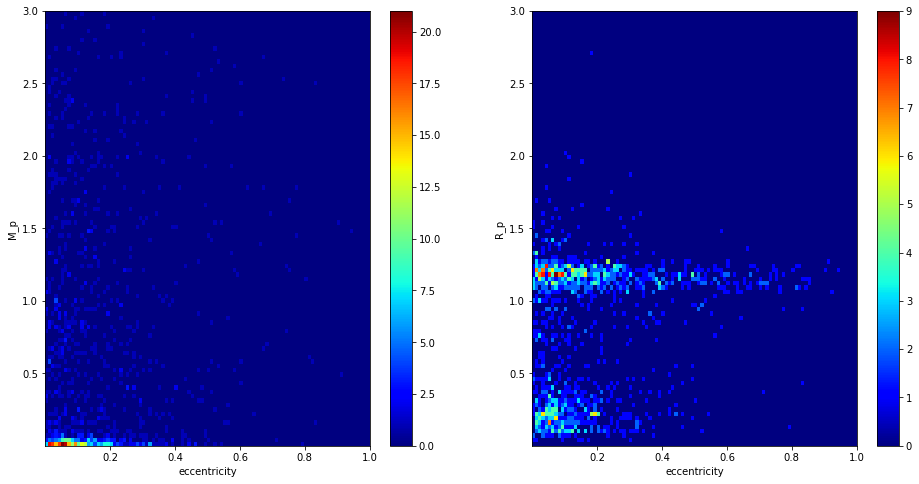

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
H1 = ax1.hist2d(df[e],df[m_p],bins=100, cmap=cm.jet, range=[[1e-5,1],[1e-5,3]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('eccentricity')
ax1.set_ylabel('M_p')
fig.colorbar(H1[3],ax=ax1)
H2 = ax2.hist2d(df[e],df[r_p],bins=100, cmap=cm.jet, range=[[1e-5,1],[1e-5,3]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity')
ax2.set_ylabel('R_p')
fig.colorbar(H2[3],ax=ax2)


In [19]:
rho = df_hist[m_p][df_hist[m_p]>0.5]/(4*np.pi*df_hist[r_p][df_hist[m_p]>0.5]**3/3)

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,7))

H1 = ax1.hist2d(df_hist[e],df_hist[m_p],bins=100, cmap=cm.jet,cmax=5, range=[[1e-5,1],[1e-5,3]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('eccentricity',fontsize=20)
ax1.set_ylabel('M_p',fontsize=20)
fig.colorbar(H1[3],ax=ax1)

H2 = ax2.hist2d(df_hist[e],df_hist[r_p],bins=100, cmax=5,cmap=cm.jet,range=[[1e-5,1],[1e-5,2.3]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity',fontsize=20)
ax2.set_ylabel('R_p',fontsize=20)
fig.colorbar(H2[3],ax=ax2)

H3 = ax3.hist2d(df_hist[e][df_hist[m_p]>0.5],rho,bins=100, cmap=cm.jet,range=[[1e-5,1],[1e-5,1.5]])
#ax2.set_ylim(0,2)
ax3.set_xlabel('eccentricity',fontsize=20)
ax3.set_ylabel('density',fontsize=20)
fig.colorbar(H3[3],ax=ax3)

In [62]:
plt.hist(df_hist[m_p]/(4*np.pi*df_hist[r_p]**3/3),range=[0.2,3],bins=100)

(array([23., 20., 15., 17., 10., 10., 10.,  8.,  6., 11.,  5.,  5.,  7.,
         6.,  5.,  6.,  6.,  4.,  7.,  8.,  7.,  2.,  0.,  6.,  5.,  4.,
         2.,  1.,  3.,  4.,  2.,  1.,  1.,  2.,  2.,  0.,  5.,  4.,  2.,
         2.,  2.,  4.,  3.,  2.,  3.,  2.,  2.,  0.,  2.,  1.,  1.,  1.,
         0.,  2.,  0.,  1.,  1.,  3.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.]),
 array([0.2  , 0.228, 0.256, 0.284, 0.312, 0.34 , 0.368, 0.396, 0.424,
        0.452, 0.48 , 0.508, 0.536, 0.564, 0.592, 0.62 , 0.648, 0.676,
        0.704, 0.732, 0.76 , 0.788, 0.816, 0.844, 0.872, 0.9  , 0.928,
        0.956, 0.984, 1.012, 1.04 , 1.068, 1.096, 1.124, 1.152, 1.18 ,
        1.208, 1.236, 1.264, 1.292, 1.32 , 1.348, 1.376, 1.404, 1.432,
        1.46 , 1.488, 1.516, 1.544, 1.572, 1.6  , 1.628, 1.656, 1.684,
        

In [63]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,7))
H1 = ax1.hist2d(df_hist[e],df_hist[m_s],bins=100, cmap=cm.jet, cmax=5,range=[[1e-5,1],[1e-5,4]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('eccentricity',fontsize=20)
ax1.set_ylabel('M_s',fontsize=20)
fig.colorbar(H1[3],ax=ax1)
H2 = ax2.hist2d(df_hist[e],df_hist[r_s],bins=100, cmap=cm.jet,cmax=5,range=[[1e-5,1],[1e-5,4]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity',fontsize=20)
ax2.set_ylabel('R_s',fontsize=20)
fig.colorbar(H2[3],ax=ax2)
H3 = ax3.hist2d(df_hist[m_s],df_hist[r_s],bins=100, cmap=cm.jet,cmax=5, range=[[1e-5,4],[1e-5,4]])
#ax2.set_ylim(0,2)
ax3.set_xlabel('M_s',fontsize=20)
ax3.set_ylabel('R_s',fontsize=20)
fig.colorbar(H3[3],ax=ax3)

Text(0, 0.5, 'density')

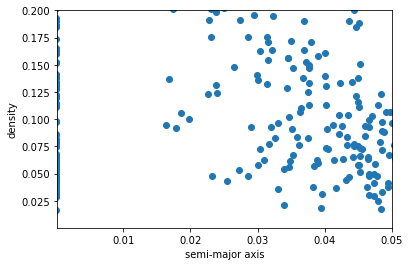

In [97]:
rho2 = df_hist[m_p][df_hist[r_p]>0.5]/(4*np.pi*df_hist[r_p][df_hist[r_p]>0.5]**3/3)
plt.scatter(df_hist[a][df_hist[r_p]>0.5],rho2)
plt.xlim(1e-4,0.05)
plt.ylim(1e-4,0.2)
plt.xlabel('semi-major axis')
plt.ylabel('density')

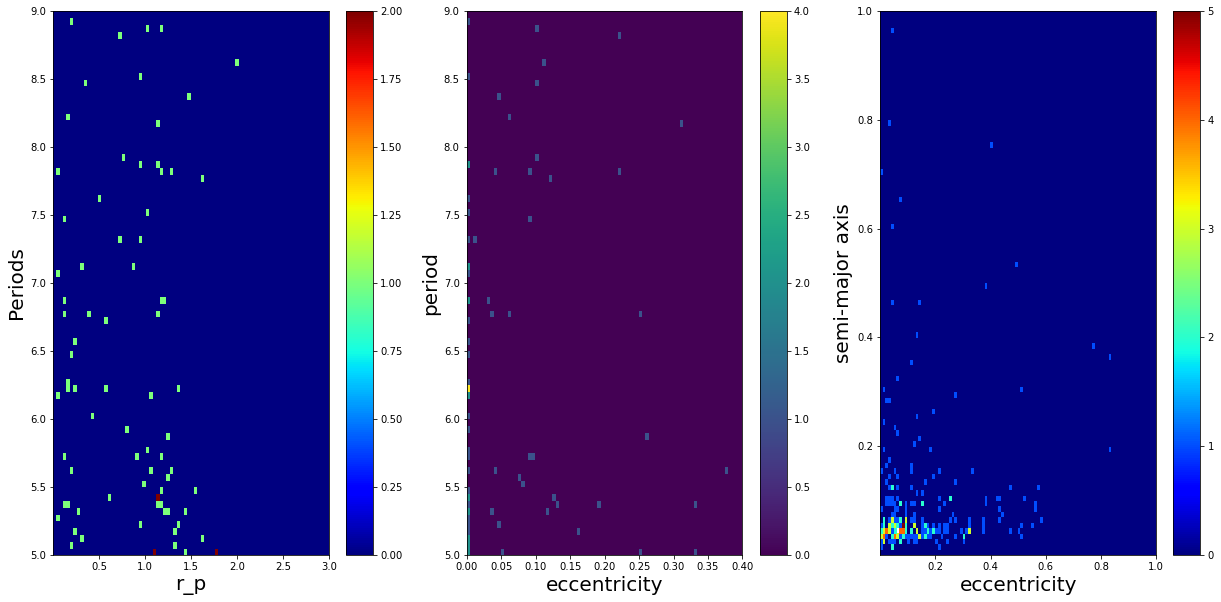

In [121]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,10))
H1 = ax1.hist2d(df_hist[r_p],df_hist[p],bins=80, cmap=cm.jet,range=[[1e-5,3],[5,9]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('r_p',fontsize=20)
ax1.set_ylabel('Periods',fontsize=20)
fig.colorbar(H1[3],ax=ax1)
H2 = ax2.hist2d(df_hist[e],df_hist[p],bins=80, cmap=cm.viridis,range=[[0,0.4],[5,9]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity',fontsize=20)
ax2.set_ylabel('period',fontsize=20)
fig.colorbar(H2[3],ax=ax2)
H3 = ax3.hist2d(df_hist[e],df_hist[a],bins=100, cmap=cm.jet,cmax=5, range=[[1e-5,1],[1e-5,1]])
#ax2.set_ylim(0,2)
ax3.set_xlabel('eccentricity',fontsize=20)
ax3.set_ylabel('semi-major axis',fontsize=20)
fig.colorbar(H3[3],ax=ax3)

(array([ 23.,  70., 105., 145.,  93.,  37.,  17.,  15.,  10.,  16.]),
 array([ 0.01 ,  1.009,  2.008,  3.007,  4.006,  5.005,  6.004,  7.003,
         8.002,  9.001, 10.   ]),
 <BarContainer object of 10 artists>)

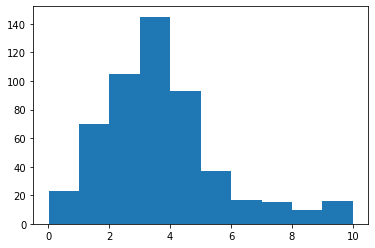

In [113]:
plt.hist(df_hist[p],range=[1e-2,10],bins=10)

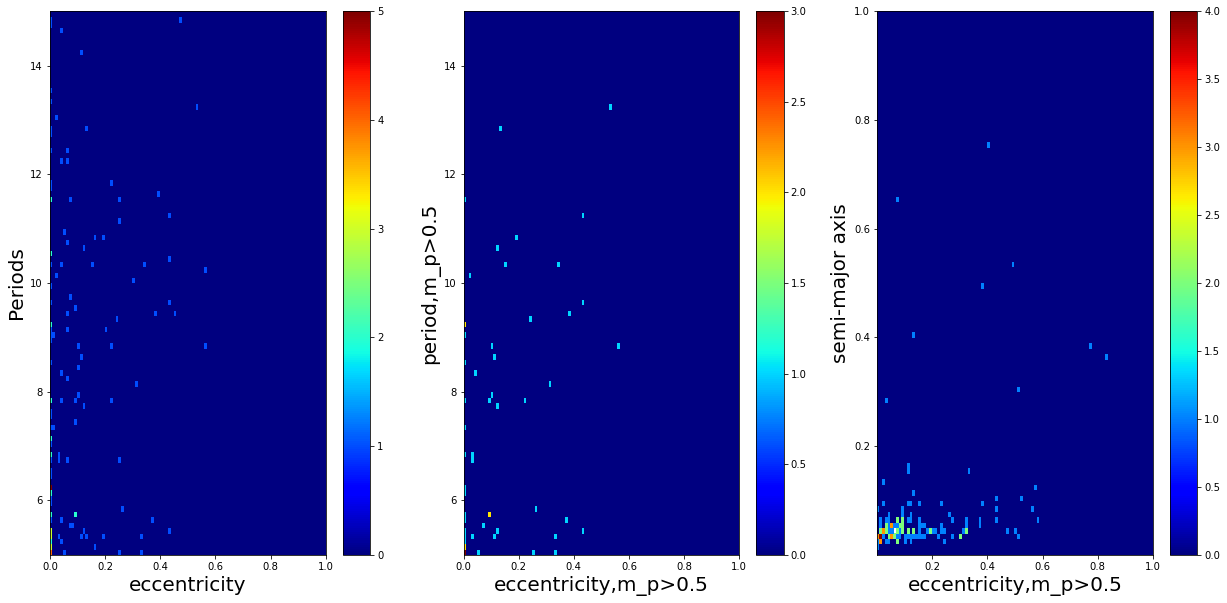

In [65]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,10))
H1 = ax1.hist2d(df_hist[e],df_hist[p],bins=100, cmap=cm.jet,range=[[0,1],[5,15]])
#ax1.set_ylim(0,4)
ax1.set_xlabel('eccentricity',fontsize=20)
ax1.set_ylabel('Periods',fontsize=20)
fig.colorbar(H1[3],ax=ax1)
H2 = ax2.hist2d(df_hist[e][df_hist[m_p]>0.5],df_hist[p][df_hist[m_p]>0.5],bins=100, cmap=cm.jet,range=[[0,1],[5,15]])
#ax2.set_ylim(0,2)
ax2.set_xlabel('eccentricity,m_p>0.5',fontsize=20)
ax2.set_ylabel('period,m_p>0.5',fontsize=20)
fig.colorbar(H2[3],ax=ax2)
H3 = ax3.hist2d(df_hist[e][df_hist[m_p]>0.5],df_hist[a][df_hist[m_p]>0.5],bins=100, cmap=cm.jet,cmax=5, range=[[1e-5,1],[1e-5,1]])
#ax2.set_ylim(0,2)
ax3.set_xlabel('eccentricity,m_p>0.5',fontsize=20)
ax3.set_ylabel('semi-major axis',fontsize=20)
fig.colorbar(H3[3],ax=ax3)

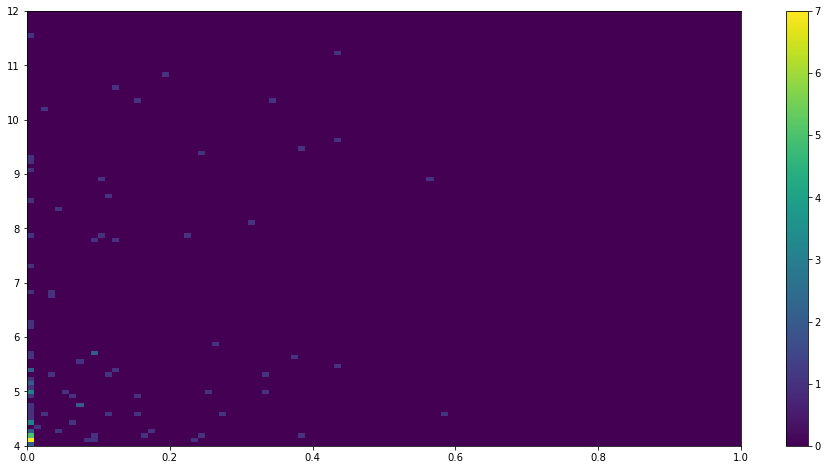

In [66]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
map1 = ax.hist2d(df_hist[e][df_hist[m_p]>0.5],df_hist[p][df_hist[m_p]>0.5],bins=100, cmap=cm.viridis,range=[[0,1],[4,12]])
plt.colorbar(map1[3],ax=ax)

(array([16., 10.,  8.,  7.,  4.,  5.,  3.,  4.,  5.,  4.,  5.,  7.,  7.,
         2.,  6.,  8.,  3.,  3.,  6.,  7.,  3.,  6.,  5.,  7.,  9.,  6.,
         7.,  8.,  4.,  4.,  8., 10.,  2.,  3.,  7.,  3.,  4.,  5.,  7.,
         4., 13.,  3.,  6.,  4.,  8.,  5.,  6.,  5.,  4.,  1.,  5.,  1.,
         6.,  3.,  3.,  2.,  1.,  7.,  5.,  3.,  6.,  2.,  5.,  3.,  4.,
         5.,  2.,  2.,  3.,  1.,  2.,  3.,  5.,  3.,  1.,  1.,  1.,  0.,
         2.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  3.,  3.,  0.,
         2.,  2.,  3.,  1.,  2.,  3.,  1.,  1.,  0.]),
 array([0.06  , 0.0794, 0.0988, 0.1182, 0.1376, 0.157 , 0.1764, 0.1958,
        0.2152, 0.2346, 0.254 , 0.2734, 0.2928, 0.3122, 0.3316, 0.351 ,
        0.3704, 0.3898, 0.4092, 0.4286, 0.448 , 0.4674, 0.4868, 0.5062,
        0.5256, 0.545 , 0.5644, 0.5838, 0.6032, 0.6226, 0.642 , 0.6614,
        0.6808, 0.7002, 0.7196, 0.739 , 0.7584, 0.7778, 0.7972, 0.8166,
        0.836 , 0.8554, 0.8748, 0.8942, 0.9136, 0.933 , 0.9524, 0.9718,
  

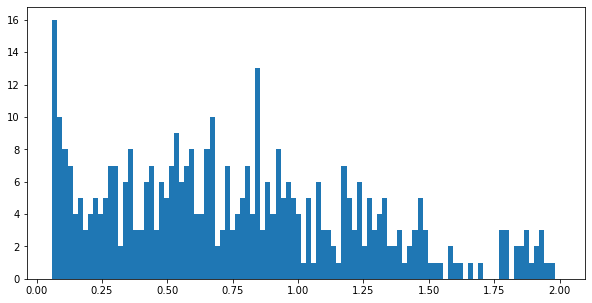

In [83]:
plt.figure(figsize=(10,5))
plt.hist(df_hist[m_p],range=[0.06,2],bins=100)

## find targets

Text(0, 0.5, 'R_p')

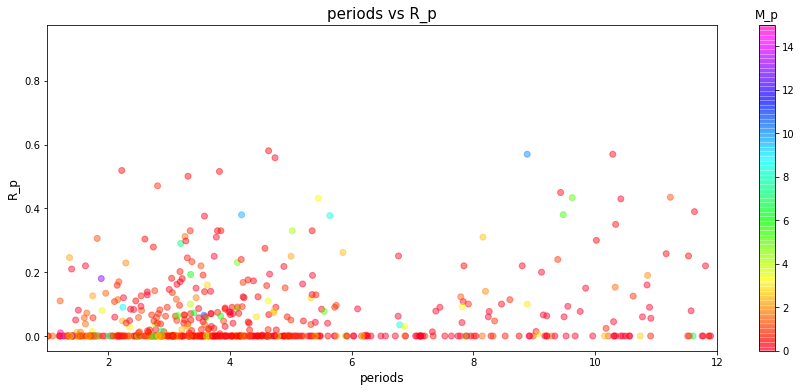

In [18]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_all[p], df_all[e], c=df_all[m_p], cmap='gist_rainbow', vmin=0, vmax=15, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.xlim(1,12)
#plt.ylim(0.5, 2.5)
plt.title('periods vs R_p', fontsize=15)
plt.xlabel('periods', fontsize=12)
plt.ylabel('R_p', fontsize=12)

In [24]:
df_all[(df_all[p]<95.3) & (df_all[p]> 95.2)]

pl_hostname  pl_orbeccen  st_mass  pl_bmassj  pl_orbsmax st_spstr  \
784     CoRoT-9        0.133     0.96       0.84      0.4021     G3 V   

     st_dist  pl_pnum  st_rad  pl_radj  pl_orbper  st_vsini  pl_tranflag  \
784   417.89        1    0.96    1.066  95.272656       3.5            1   

     pl_rvflag          ra       dec  pl_cbflag  
784          1  280.786712  6.204172          0

/home/yterada/anaconda3/envs/highe/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log(a * (1 - e))')

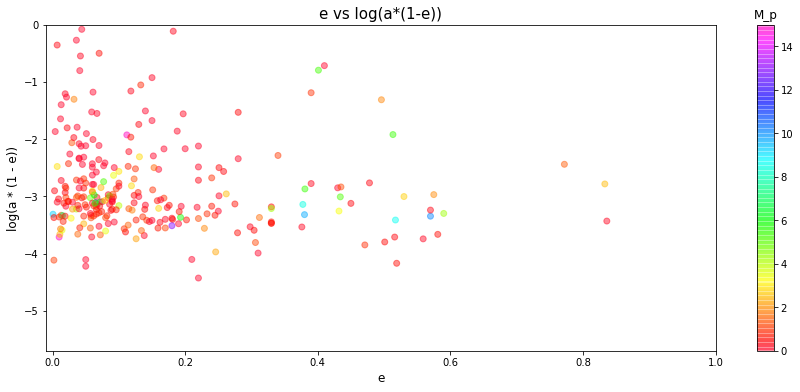

In [9]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_new[e], np.log(df_new[a]*(1-df_new[e])), c=df_new[m_p], cmap='gist_rainbow', vmin=0, vmax=15, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.ylim(-5.7,0)
plt.xlim(-0.01,1.0)
plt.title('e vs log(a*(1-e))', fontsize=15)
plt.xlabel('e', fontsize=12)
plt.ylabel('log(a * (1 - e))', fontsize=12)

### plot (d<100pc)

In [36]:
#distance<100pc
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_rv[e][df_rv[d]<100], np.log(df_rv[a][df_rv[d]<100]*(1-df_rv[e][df_rv[d]<100])), c=df_rv[m_p][df_rv[d]<100], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.ylim(-5.7,0)
plt.xlim(-0.01,1.0)
plt.title('e vs log(a*(1-e))', fontsize=15)
plt.xlabel('e', fontsize=12)
plt.ylabel('log(a * (1 - e))', fontsize=12)

/home/yterada/anaconda3/envs/highe/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log(a * (1 - e))')

Text(0, 0.5, 'e')

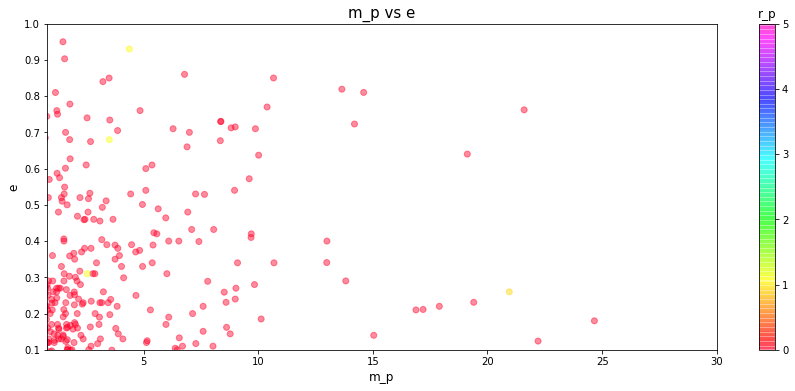

In [43]:
#distance<100pc
plt.figure(figsize=(15,6))
#map2 = plt.scatter(df_new[r_p], df_new[e], c=df_new[m_p], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.45)
#map2 = plt.scatter(df_new[m_p][df_new[d]<100], df_new[e][df_new[d]<100], c=df_new[r_p][df_new[d]<100], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.45)
map2 = plt.scatter(df_rv[m_p][df_rv[d]<100], df_rv[e][df_rv[d]<100], c=df_rv[r_p][df_rv[d]<100], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('r_p')
plt.ylim(0.1,1.0)
plt.xlim(0.8,30)

plt.title('m_p vs e', fontsize=15)
plt.xlabel('m_p', fontsize=12)
plt.ylabel('e', fontsize=12)

In [60]:
df_rv_new = df[(df[e]> 0.1) & (df[d]!= 0.000) & (df[d] < 100 ) & (df['pl_rvflag']!=0) & (df[m_p] > 0.8 )]
len(df_rv_new)

231

In [59]:
df2[(df2['p_ps']< 1.0)]

pl_hostname  pl_orbeccen  st_mass  pl_bmassj  pl_orbsmax st_spstr  \
345           55 Cnc       0.0500     0.91    0.02514     0.01544     G8 V   
2843  PSR J2322-2650       0.0017     1.40    0.79490     0.01020        0   
4272         HATS-69       0.5190     0.89    0.57700     0.03211        0   

      st_dist  pl_pnum  st_rad  pl_radj  pl_orbper  pl_tranflag  pl_rvflag  \
345     12.59        5    0.94    0.167   0.736547            1          1   
2843   230.00        1    0.00    0.000   0.322964            0          0   
4272   420.30        1    0.88    0.945   2.225258            1          1   

              ra        dec  pl_cbflag  Omega_ps_n  Omega_ps_n_p        n_p  \
345   133.149216  28.330818          0    1.015003      0.917187   9.440357   
2843  350.644348 -26.849533          0    1.000017      0.996622  19.521041   
4272  289.297350 -60.891683          0    2.996377      0.811027  10.431838   

          p_ps  
345   0.725661  
2843  0.322958  
4272  0.742649

<ipython-input-56-20f0248d47e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Omega_ps_n'] = _omega_ps_n(df2[e])
<ipython-input-56-20f0248d47e8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Omega_ps_n_p'] = _omega_ps_n_p(df2[e])
<ipython-input-56-20f0248d47e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

(array([0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 2., 3., 2., 2., 3., 1.,
        2., 5., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

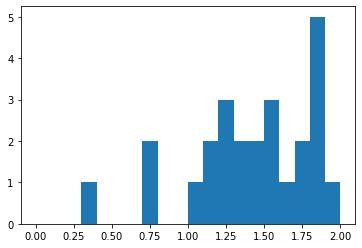

In [56]:
df2 = df[(df[e]!= 0.000) & (df[p]!= 0.000) & (df[m_p] < 0.8 )]
df2['Omega_ps_n'] = _omega_ps_n(df2[e])
df2['Omega_ps_n_p'] = _omega_ps_n_p(df2[e])
df2['n_p'] = _n_p(df2[e],df2[p])
df2['p_ps'] = 2 * np.pi/(df2['Omega_ps_n_p'] * df2['n_p'])
plt.hist(df2['p_ps'],range=(0,2),bins=20)

<ipython-input-61-eb3de8e9fd21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rv_new['Omega_ps_n'] = _omega_ps_n(df_rv_new[e])
<ipython-input-61-eb3de8e9fd21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rv_new['Omega_ps_n_p'] = _omega_ps_n_p(df_rv_new[e])
<ipython-input-61-eb3de8e9fd21>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

(array([0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 4., 1., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

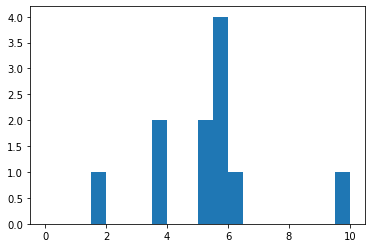

In [61]:
df_rv_new['Omega_ps_n'] = _omega_ps_n(df_rv_new[e])
df_rv_new['Omega_ps_n_p'] = _omega_ps_n_p(df_rv_new[e])
df_rv_new['n_p'] = _n_p(df_rv_new[e],df_rv_new[p])
df_rv_new['p_ps'] = 2 * np.pi/(df_rv_new['Omega_ps_n_p'] * df_rv_new['n_p'])
plt.hist(df_rv_new['p_ps'],range=(0,10),bins=20)

In [95]:
#single star/ puffy
print(df_new.loc[3546])
#single star/ 2 planets/ outer planet 3Mj
print(df_new.loc[768])
#single star system
print(df_new.loc[961])
#binary
print(df_new.loc[752])
print(df_new.loc[3456])

pl_hostname    HD 221416
pl_orbeccen        0.115
st_mass             1.21
pl_bmassj           0.19
pl_orbsmax        0.1228
st_spstr         K0 IV/V
st_dist            95.08
pl_pnum                1
pl_radj            0.836
pl_orbper        14.2767
pl_tranflag            1
pl_rvflag              1
ra             353.03363
dec           -21.801424
pl_cbflag              0
Name: 3546, dtype: object
pl_hostname      HAT-P-17
pl_orbeccen          0.35
st_mass              0.99
pl_bmassj            0.58
pl_orbsmax            0.0
st_spstr                K
st_dist             92.63
pl_pnum                 2
pl_radj              1.05
pl_orbper        10.33852
pl_tranflag             1
pl_rvflag               1
ra             324.536396
dec             30.488716
pl_cbflag               0
Name: 768, dtype: object
pl_hostname     HD 17156
pl_orbeccen         0.68
st_mass             1.41
pl_bmassj           3.51
pl_orbsmax           0.0
st_spstr            G0 V
st_dist            78.26
pl_pnum  

### find target

In [10]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_new[a], df_new[e], c=df_new[r_p], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.45)
clb2 = plt.colorbar(map2)
plt.xlim(0,0.2)
plt.xlabel('semi-major axis[au]', fontsize=12)
plt.ylabel('eccentricity', fontsize=12)
#clb2.ax.set_title('M_p')

Text(0, 0.5, 'eccentricity')

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(df_new[r_p],df_new[m_p])
plt.xlim(0,3)
plt.ylim(0,3)
plt.xlabel('radius[R_J]')
plt.ylabel('mass[M_J]')

Text(0, 0.5, 'mass[M_J]')

In [12]:
plt.figure(figsize=(15,6))
map2 = plt.scatter(df_new[m_s][df_new[d]<100], np.log(df_new[a][df_new[d]<100]*(1-df_new[e][df_new[d]<100])), c=df_new[m_p][df_new[d]<100], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.45)
clb2 = plt.colorbar(map2)
clb2.ax.set_title('M_p')
plt.ylim(-5.152,-5.148)
plt.xlim(0.45999,0.460015)
#plt.title('e vs log(a*(1-e))', fontsize=15)
#plt.xlabel('e', fontsize=12)
#plt.ylabel('log(a * (1 - e))', fontsize=12)

(0.45999, 0.460015)

In [13]:
df_new.loc[(df_new[m_s]>=0.45999) & (df_new[m_s]<=0.460015)]

pl_hostname  pl_orbeccen  st_mass  pl_bmassj  pl_orbsmax st_spstr  \
3663      K2-137          0.0     0.46        0.5     0.00580     M3 V   
3904      K2-133          0.0     0.46        0.0     0.13460   M1.5 V   
4173      K2-150          0.0     0.46        0.0     0.07270   M2.5 V   
4338      K2-133          0.0     0.46        0.0     0.03194   M1.5 V   
4339      K2-133          0.0     0.46        0.0     0.04341   M1.5 V   
4340      K2-133          0.0     0.46        0.0     0.07487   M1.5 V   

      st_dist  pl_pnum  pl_radj  pl_orbper  
3663    99.15        1    0.079   0.179715  
3904    75.20        4    0.154  26.584100  
4173   110.00        1    0.178  10.593570  
4338    75.20        4    0.120   3.071330  
4339    75.20        4    0.143   4.867840  
4340    75.20        4    0.179  11.024540

## estimate rotation periods

### equations

Orbital velocity: $ v = \sqrt{\mu \ ( \frac{2}{r} - \frac{1}{a})}$   
  
$r$: periastron(in this time), $r = a(1-e)$   
$\mu$: standard gravitational parameter, $ \mu=G(M_S + M_p) \sim GM_S$

In [15]:
#Ploblem: somothing wrong with digit (R_p)
df_new['v_max'] = np.sqrt(const.G*df_new[m_s]*const.M_sun * (2/(df_new[a]*(1-df_new[e])*const.au) - 1/(df_new[a]*const.au)))
df_new['rot_p'] = (2 * np.pi * df_new[r_p]*const.R_jup) / df_new['v_max']

<ipython-input-15-1c539e7a8b59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['v_max'] = np.sqrt(const.G*df_new[m_s]*const.M_sun * (2/(df_new[a]*(1-df_new[e])*const.au) - 1/(df_new[a]*const.au)))
<ipython-input-15-1c539e7a8b59>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rot_p'] = (2 * np.pi * df_new[r_p]*const.R_jup) / df_new['v_max']


### test2: HATS-69

In [17]:
df_new.loc[(df_new[e]>=0.5185) & (df_new[e]<=0.5195) & (df_new[m_p]<=3.0)]

pl_hostname  pl_orbeccen  st_mass  pl_bmassj  pl_orbsmax st_spstr  \
3734     HATS-69        0.519     0.89      0.577     0.03211        0   

      st_dist  pl_pnum  pl_radj  pl_orbper          v_max       rot_p  
3734    420.3        1    0.945   2.225258  278659.793069  1523.33287

In [39]:
ind=3734

# min distance = a(1-e)
min_dist = df_new.loc[ind][a]*(1-df_new.loc[ind][e])
min_dist

0.01544491

In [40]:
v = np.sqrt(const.G*df_new.loc[ind][m_s]*const.M_sun * (2/(min_dist*const.au) - 1/(df_new.loc[ind][a]*const.au)))
v

<Quantity 278659.79306858 m / s>

In [41]:
rot_p = (2 * np.pi * 0.945*const.R_jup) / v 
rot_p

<Quantity 1523.33287012 s>

In [42]:
1523/60/60/24

0.017627314814814814

### test3:PSR J1719-1438

In [19]:
df_new.loc[(df_new[m_p]>=1.195) & (df_new[m_p]<=1.205)]

pl_hostname  pl_orbeccen  st_mass  pl_bmassj  pl_orbsmax st_spstr  \
3147  PSR J1719-1438         0.06      1.4        1.2      0.0044        0   

      st_dist  pl_pnum  pl_radj  pl_orbper          v_max  rot_p  
3147   1200.0        1      0.0   0.090706  564182.740949    0.0

In [25]:
ind=3147
df_new.loc[ind][name]

'PSR J1719-1438'

In [26]:
ind=3141

# min distance = a(1-e)
min_dist = df_new.loc[ind][a]*(1-df_new.loc[ind][e])
min_dist

0.06

In [27]:
v = np.sqrt(const.G*1.4*const.M_sun * (2/(min_dist*const.au) - 1/(df_new.loc[ind][a]*const.au)))
v

<Quantity 143873.730191 m / s>

In [29]:
rot_p = (2 * np.pi * 0.59*const.R_jup) / v 
rot_p/60/3600

<Quantity 0.00852814 s>


hd80606 = NasaExoplanetArchive.query_object("HD 80606 b", select="pl_hostname,pl_pnum,pl_orbeccen,pl_bmassj,pl_radj,st_dist,st_spstr,st_mass")
hd80606

tested targets
Jupiter   
HD 221416   
HD 1397   
HAT-P-17   
HD 17156   
HD80606    
WASP-8   
WASP-19(e=0)    
HATS-69   
TOI-573b (Planet Candidate)   
HATS-71 (d=140pc)   